# Data analysis: Velib
## Projet

Author: O. Roustant, INSA Toulouse. January 2021.


We consider the ‘Vélib’ data set, related to the bike sharing system of Paris. The data are loading profiles of the bike stations over one week, collected every hour, from the period Monday 2nd Sept. - Sunday 7th Sept., 2014. The loading profile of a station, or simply loading, is defined as the ratio of number of available bikes divided by the number of bike docks. A loading of 1 means that the station is fully loaded, i.e. all bikes are available. A loading of 0 means that the station is empty, all bikes have been rent.

From the viewpoint of data analysis, the individuals are the stations. The variables are the 168 time steps (hours in the week). The aim is to detect clusters in the data, corresponding to common customer usages. This clustering should then be used to predict the loading profile.

In [31]:
rm(list = ls())   # erase everything, start from scratch!
# load the data from package funFEM
library(funFEM)
data(velib)
#help("velib")

Warning message:
"package 'funFEM' was built under R version 3.6.3"
Loading required package: MASS

Loading required package: fda

Warning message:
"package 'fda' was built under R version 3.6.3"
Loading required package: splines

Loading required package: Matrix

Loading required package: fds

Warning message:
"package 'fds' was built under R version 3.6.3"
Loading required package: rainbow

Warning message:
"package 'rainbow' was built under R version 3.6.3"
Loading required package: pcaPP

Warning message:
"package 'pcaPP' was built under R version 3.6.3"
Loading required package: RCurl

Warning message:
"package 'RCurl' was built under R version 3.6.3"

Attaching package: 'fda'


The following object is masked from 'package:graphics':

    matplot


Loading required package: elasticnet

Warning message:
"package 'elasticnet' was built under R version 3.6.3"
Loading required package: lars

Loaded lars 1.2




In [32]:
# data preparation
x <- as.matrix(velib$data)
colnames(x) <- 1:ncol(x)
rownames(x) <- velib$names

n <- nrow(x)
stations <- 1:n 
coord <- velib$position[stations,]

# select exactly 7 days of data (we remove the first 13 dates)
dates <- 14:181
x <- x[stations, dates]
colnames(x) <- 1:length(dates)

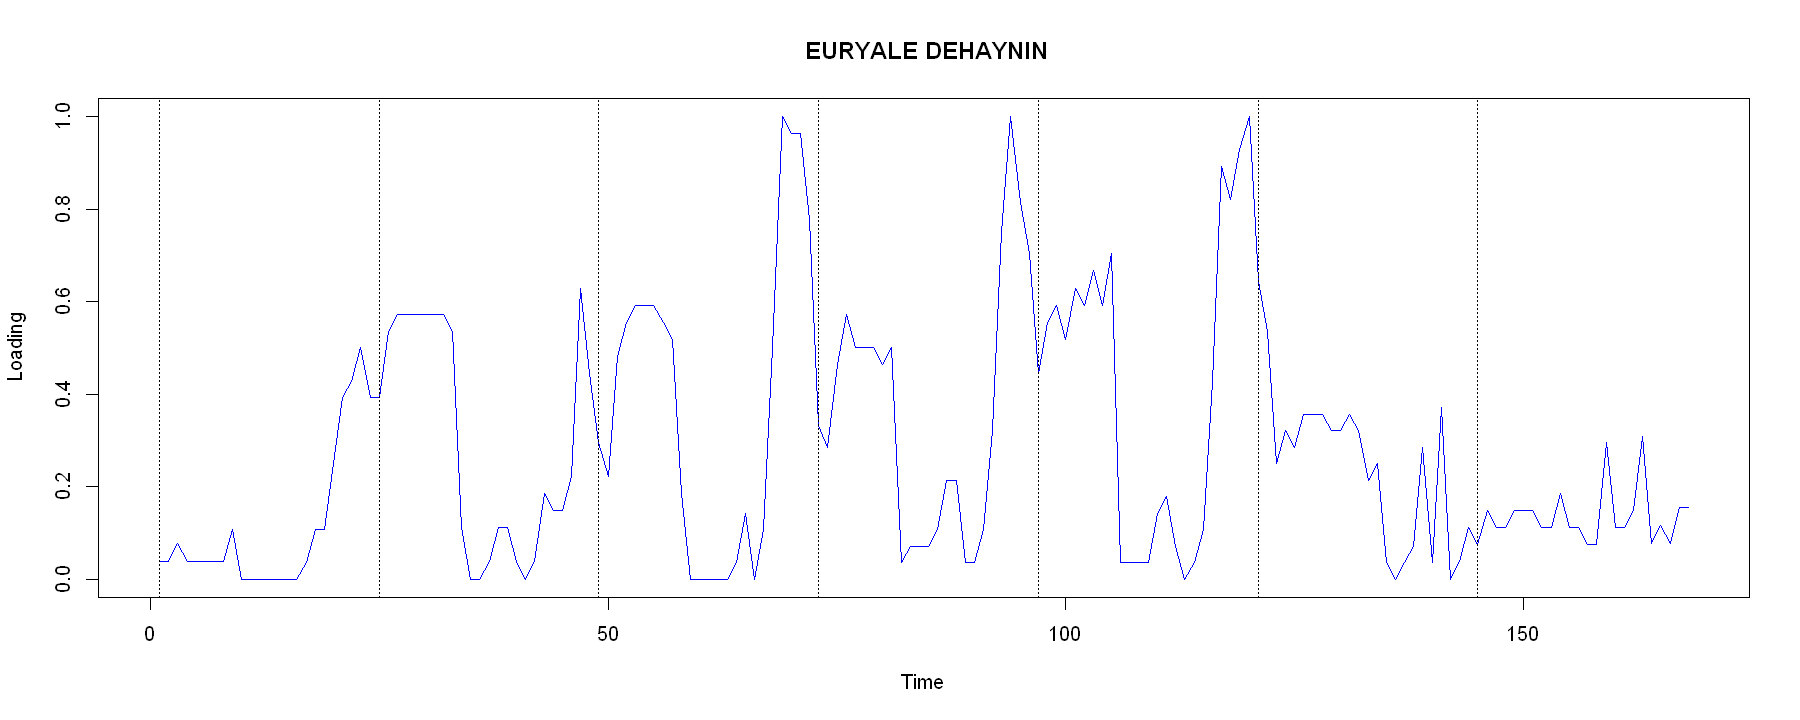

In [33]:
timeTick <- 1 + 24*(0:6)  # vector corresponding to the beginning of days
par(mfrow = c(1, 1))

options(repr.plot.width = 15, repr.plot.height = 6)

plot(x[1, ], col = "blue", type = "l", ylim = c(0, 1), 
     xlab = "Time", ylab = "Loading", main = rownames(x)[1])
abline(v = timeTick, lty = "dotted")


Commentaires:
On a ici une représentation du ratio nombre de vélos disponibles sur le nombre de vélos total pour la première station EURYALE DEHAYNIN en fonction des heures de la semaine. Les droites en pointillé permettent de distinguer les différents jours de la semaine. Pour cette station, on observe différents schémas d'occupation selon le moment de la semaine (week end, lundi-mardi, mer-jeu-ven). Le week-end, l'utilisation des vélos est beaucoup plus élevé et plus stable (moins de variabilité).


# Descriptive statistics.

1. Draw a matrix of plots of size 4*4, corresponding to the first 16 stations. (Do not forget the vertical lines corresponding to days).

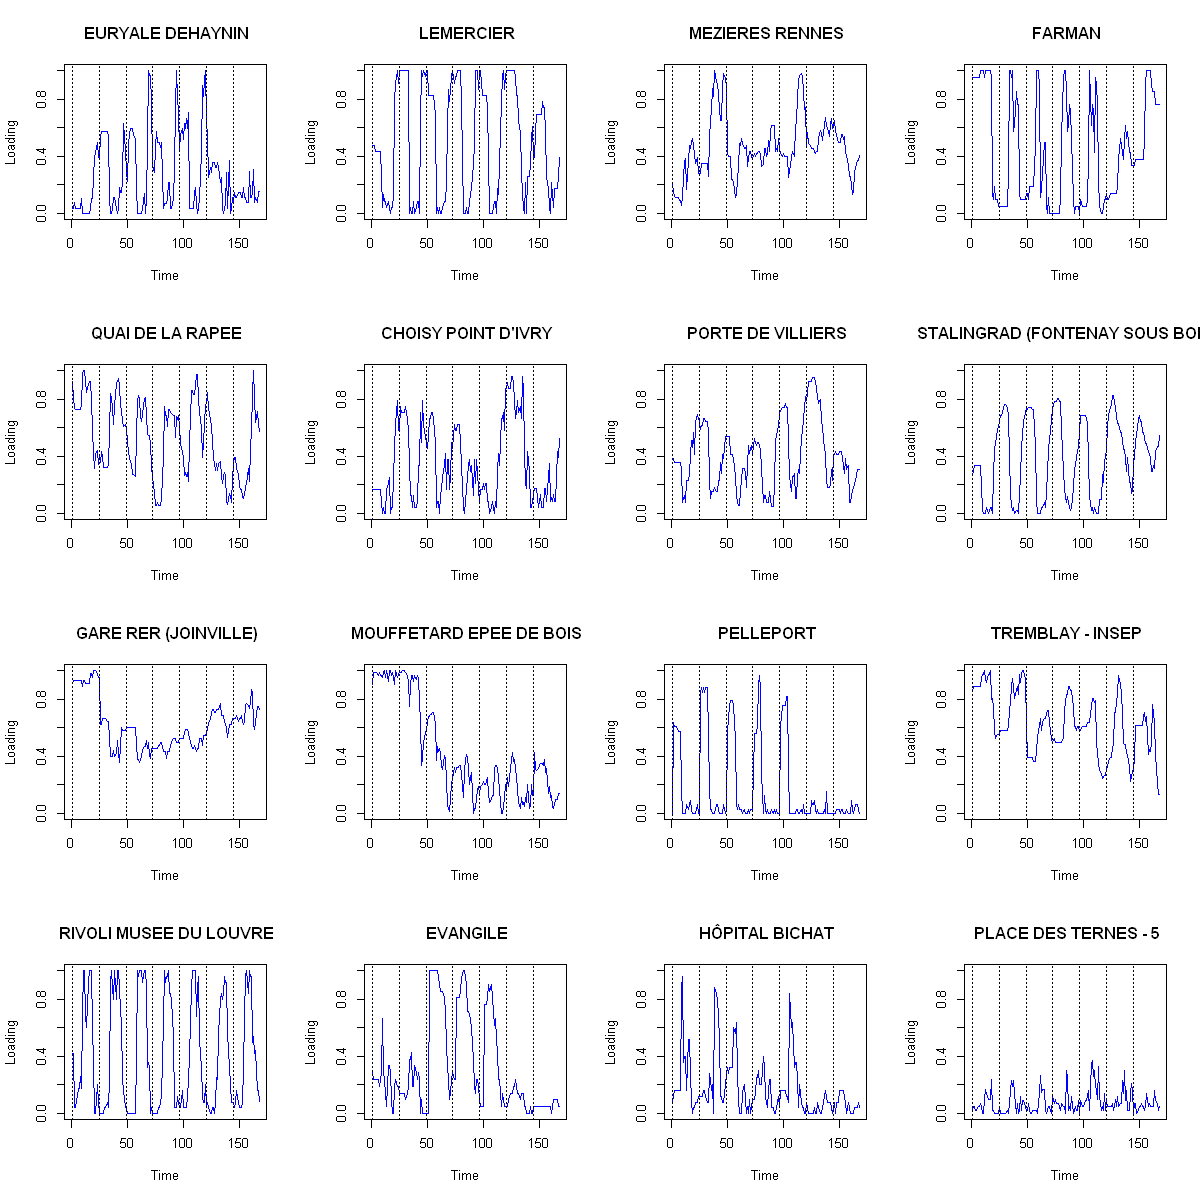

In [34]:
options(repr.plot.width = 10, repr.plot.height = 10)
par(mfrow=c(4,4))
for (i in 1:16)
{
    
    plot(x[i, ], col = "blue", type = "l", ylim = c(0, 1), 
         xlab = "Time", ylab = "Loading", main = velib$names[i])
    abline(v = timeTick, lty = "dotted")
}

Commentaires:
L'occupation des vélos différe selon les stations même si on peut retrouver des comportements proches entre certains groupes de stations. Certaines ont un rythme d'utlisation régulier tout au long de la semaine (stations du *LOUVRE*, *PLACE DES TERNES*) : pas de différence entre jours ouvrés et week end. 
La station *PLACE DES TERNES* a un taux d'utilisation particulièrement élevé. 
Pour certaines stations comme *PELLEPORT* ou *LA GARE RER*, la différence entre jours ouvrés et week end est plus marquée. 
Selon la station observé, les vélos seront plutôt utilisés en jour ou en soirée. 

In [35]:
# From now on, we use numbers instead of station names, 
# in order to simplify printing
rownames(x) <- 1:nrow(x)

2. Draw the boxplot of the variables, sorted in time order. 
What can you say about the distribution of the variables? 
Position, dispersion, symmetry?

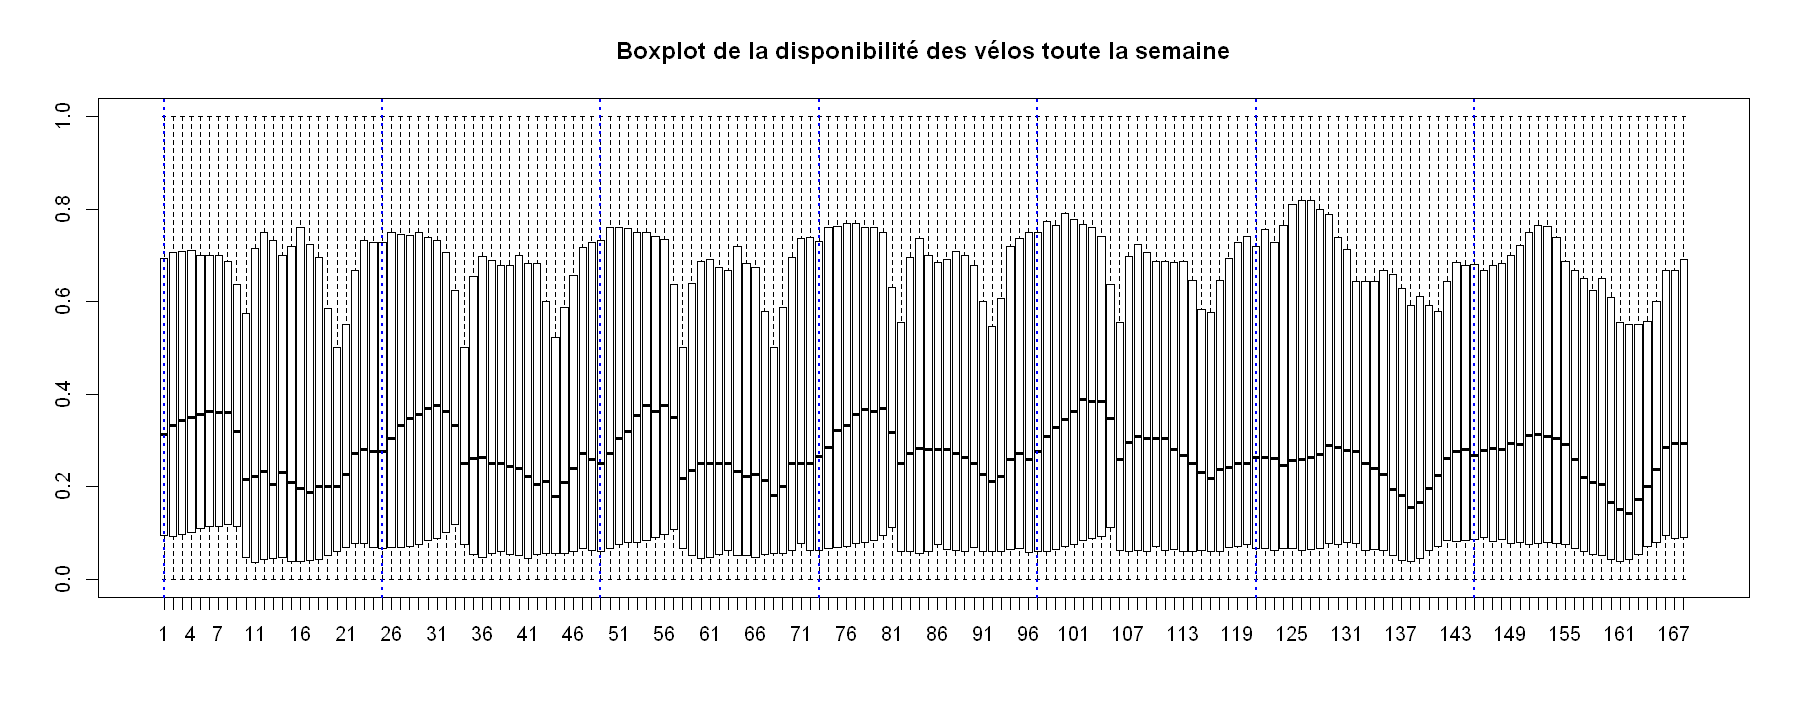

In [36]:
options(repr.plot.width = 15, repr.plot.height = 6)
boxplot(x[ , 1:ncol(x)], main="Boxplot de la disponibilité des vélos toute la semaine" ) # ou boxplot(x)
abline(v = timeTick, lty = "dotted", col = "blue", lwd = 2)

Commentaires:

Le boxplot de toutes les variables montrent que la médiane a une composante saisonnière pour les cinq premiers jours de la semaine: variation cyclique de jour en jour. Dans un jour, on a deux tendances, une croissance pendant la nuit et une décrue en  journée.

Pour ce qui est de la dispersion, on a à peu près la même échelle pour toutes les variables donc inutile de réduire les données, écart interquartile grand donc une grande dispersion entre les stations

position->médiane
dispersion-> largeur
symétrie-> ecart entre médiane et troisième quartile pareil que écart entre médiane et premier quartile?

Réponse: médiane plus proche de 0 que de 1 dans l'ensemble (dissymétrie), périodicité à la journée pour les cinq premiers jours qui est pareile et aussi pour le week end mais une périodicité différente. 
Pour les clusters, penser à la différence semaine/week end et jour/nuit.
La disymétrie est saisonnière, plus symétrique à la nuit qu'au jour et asymétrie plus marquée au week end.

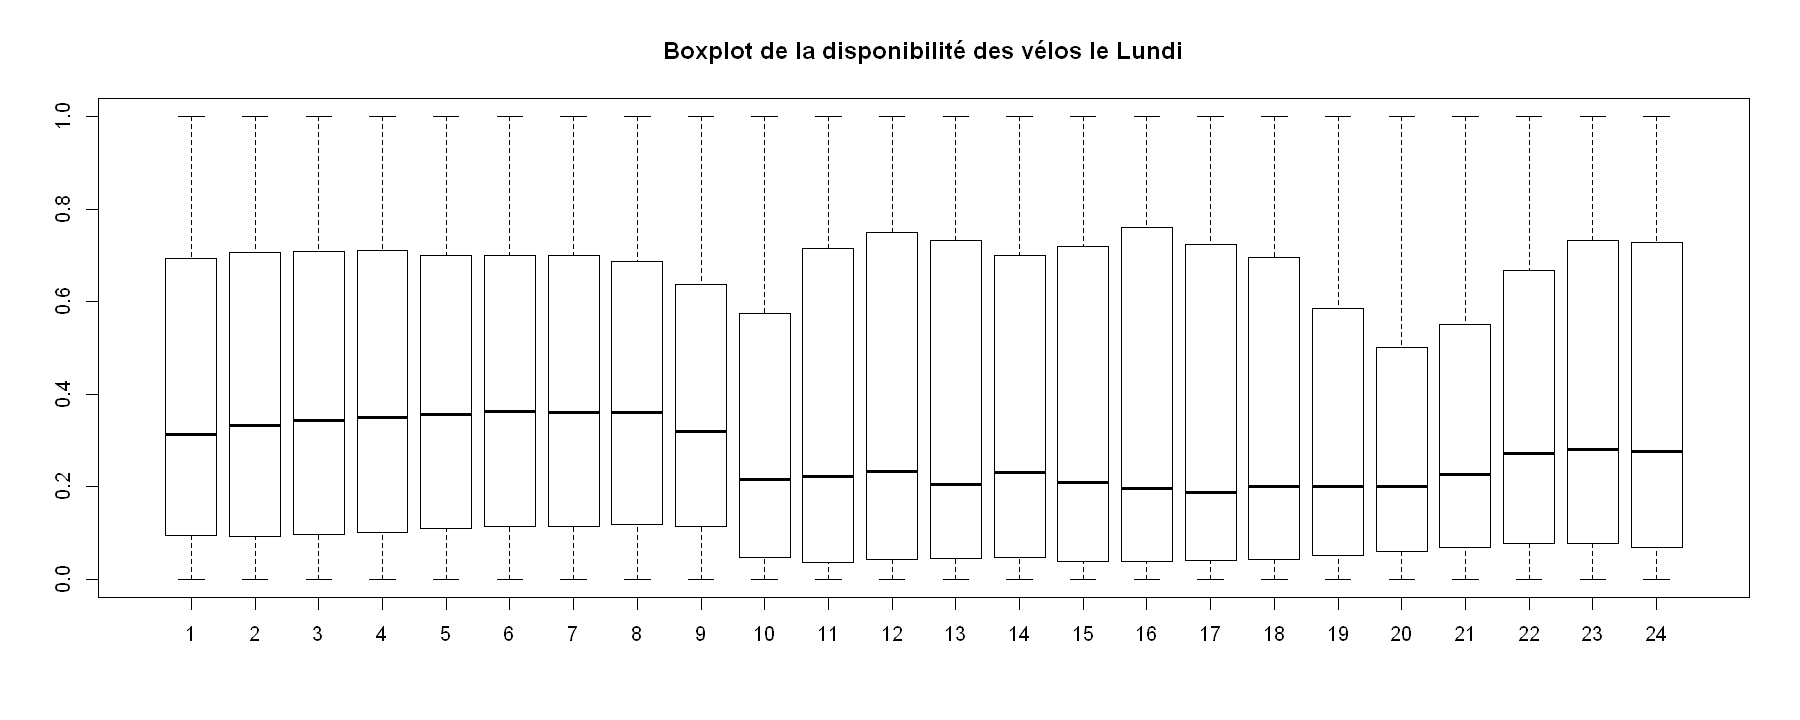

In [37]:
#boxplot pour les premières 24 heures
options(repr.plot.width = 15, repr.plot.height = 6)
boxplot(x[, 1:24],main="Boxplot de la disponibilité des vélos le Lundi")

Commentaires:

L'évolution de la médiane indique que, pour le Lundi, l'utilisation est en moyenne plus importante entre 10h et 20h et plus faible la nuit entre 22h et 09h.

3. Investigate the temporal correlation of the variables. 
For instance, for a given station, plot the loading at t+h versus loading at time t.
Visualize the correlation matrix by an image plot. Interpret the result.

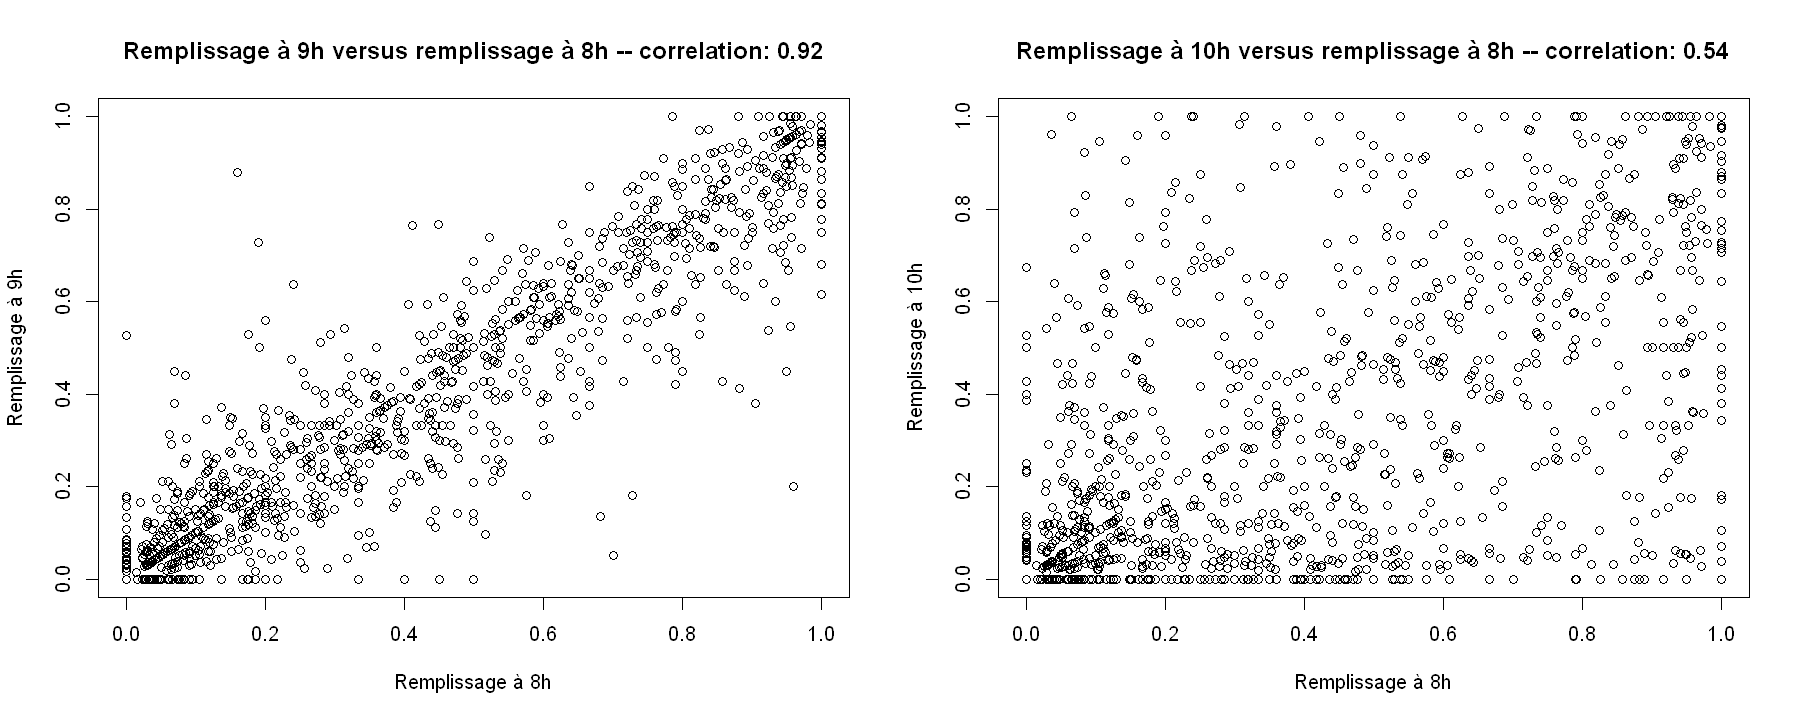

In [38]:
# Question 3


options(repr.plot.width = 15, repr.plot.height = 6)
par(mfrow=c(1,2))
t <- 8
for(h in 1:2)
{
    
    mycor <- round(cor(x[, t], x[, t+h]), 2)
    plot(x[, t], x[, t+h], main = paste("Remplissage à ", t+h, 
            "h versus remplissage à ", t, "h -- correlation: ", 
                                        mycor, sep = ""), 
        xlab = paste("Remplissage à ", t, "h", sep = ""),
        ylab = paste("Remplissage à ", t+h, "h", sep = ""))
}

Commentaires: Le remplissage des stations entre 8h et 9h est fortement corrélé (0.92) alors que entre 8h et 10h, on note une chute de corrélation (0.54) dû à un changement de phase.

Warning message:
"package 'corrplot' was built under R version 3.6.3"
corrplot 0.84 loaded



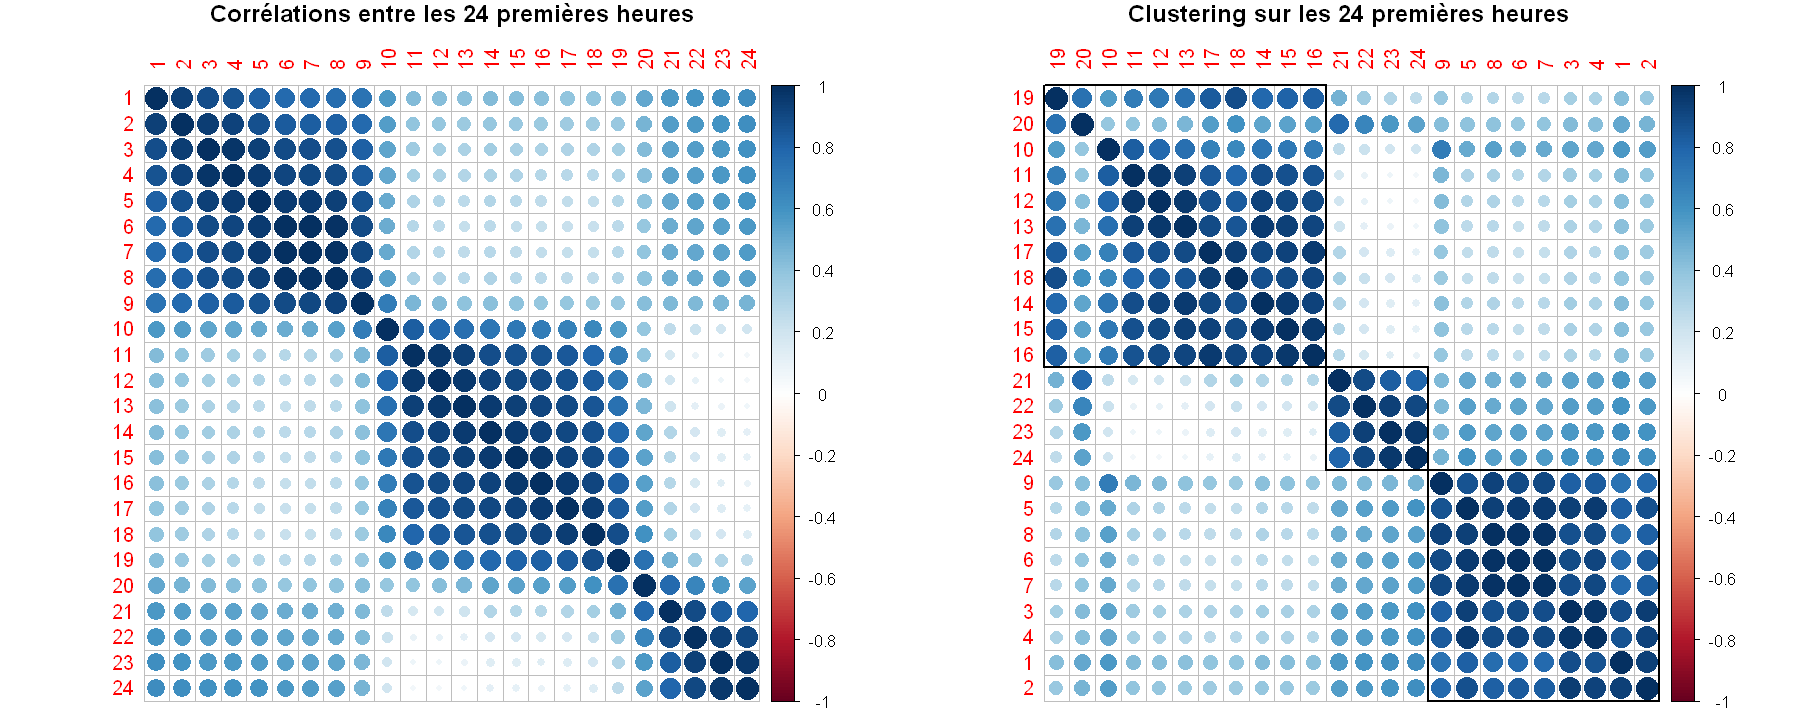

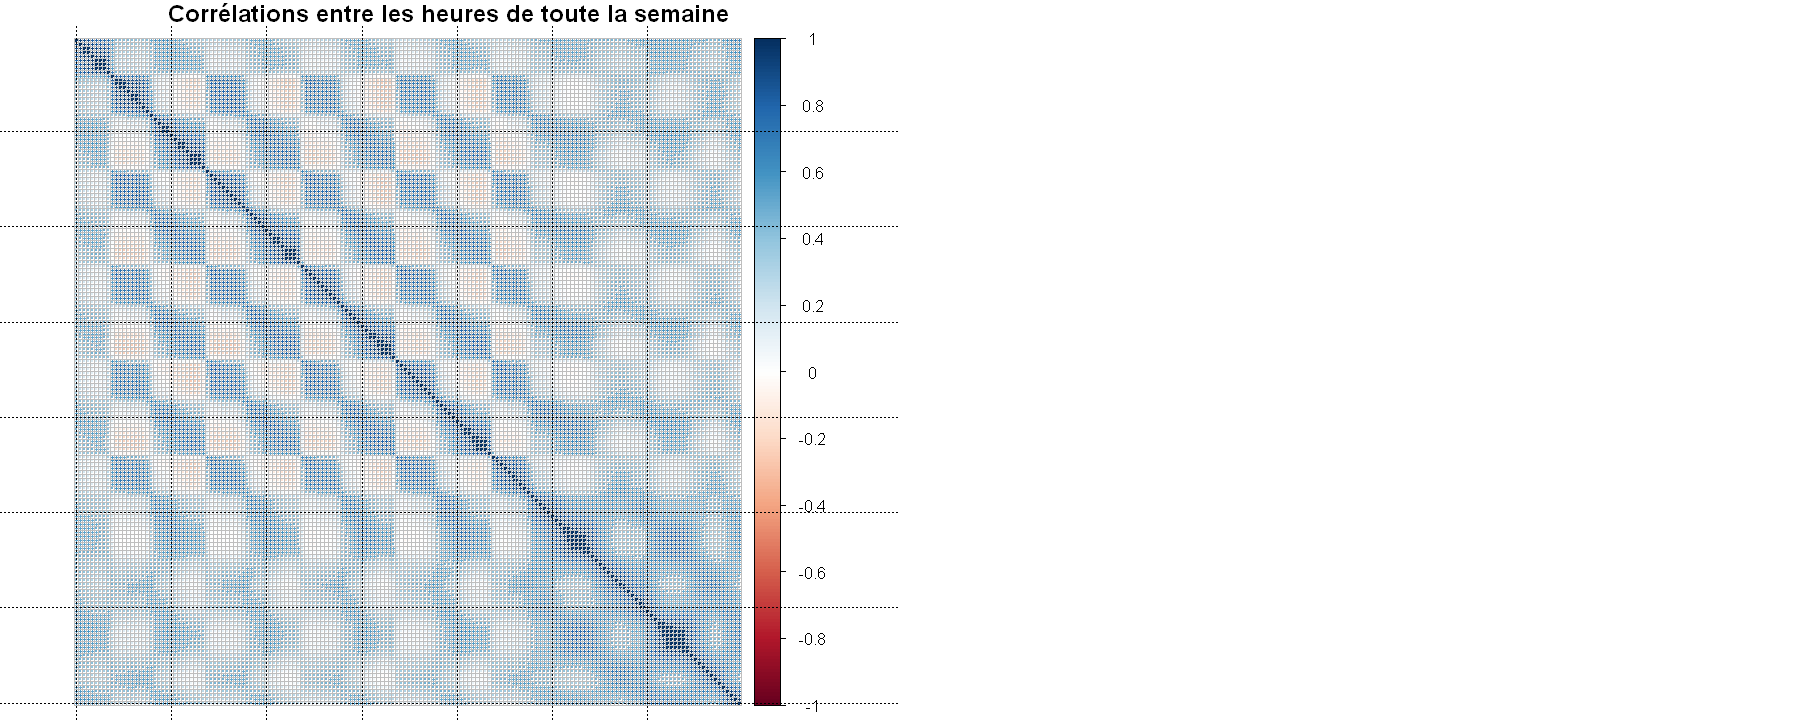

In [39]:
library(corrplot)
cormat <- cor(x) 
par(mfrow = c(1, 2))
corrplot(cormat[1:24, 1:24],title=" Corrélations entre les 24 premières heures",mar=c(0,0,1,0))
corrplot(cormat[1:24, 1:24], order = "hclust", addrect = 3, hclust.method="ward.D2",
         title="Clustering sur les 24 premières heures",mar=c(0,0,1,0))
corrplot(cormat, tl.pos = "n", title="Corrélations entre les heures de toute la semaine",mar=c(0,0,1,0))
abline(v = timeTick, h = timeTick, col = "black", lty = "dotted")



Dans une journée on note trois phases où la location des vélos est régulière (forte corrélation): de 01h à 09h, de 10h à 19h et de 20h à 24h. Avec le clustering (métrique: Ward), on retrouve les mêmes groupes d'heures.
Sur le troisième graphique, on remarque une évolution similaire pour tous les jours ouvrés de la semaine. 
En revanche, on n'observe pas le même comportement le week-end.

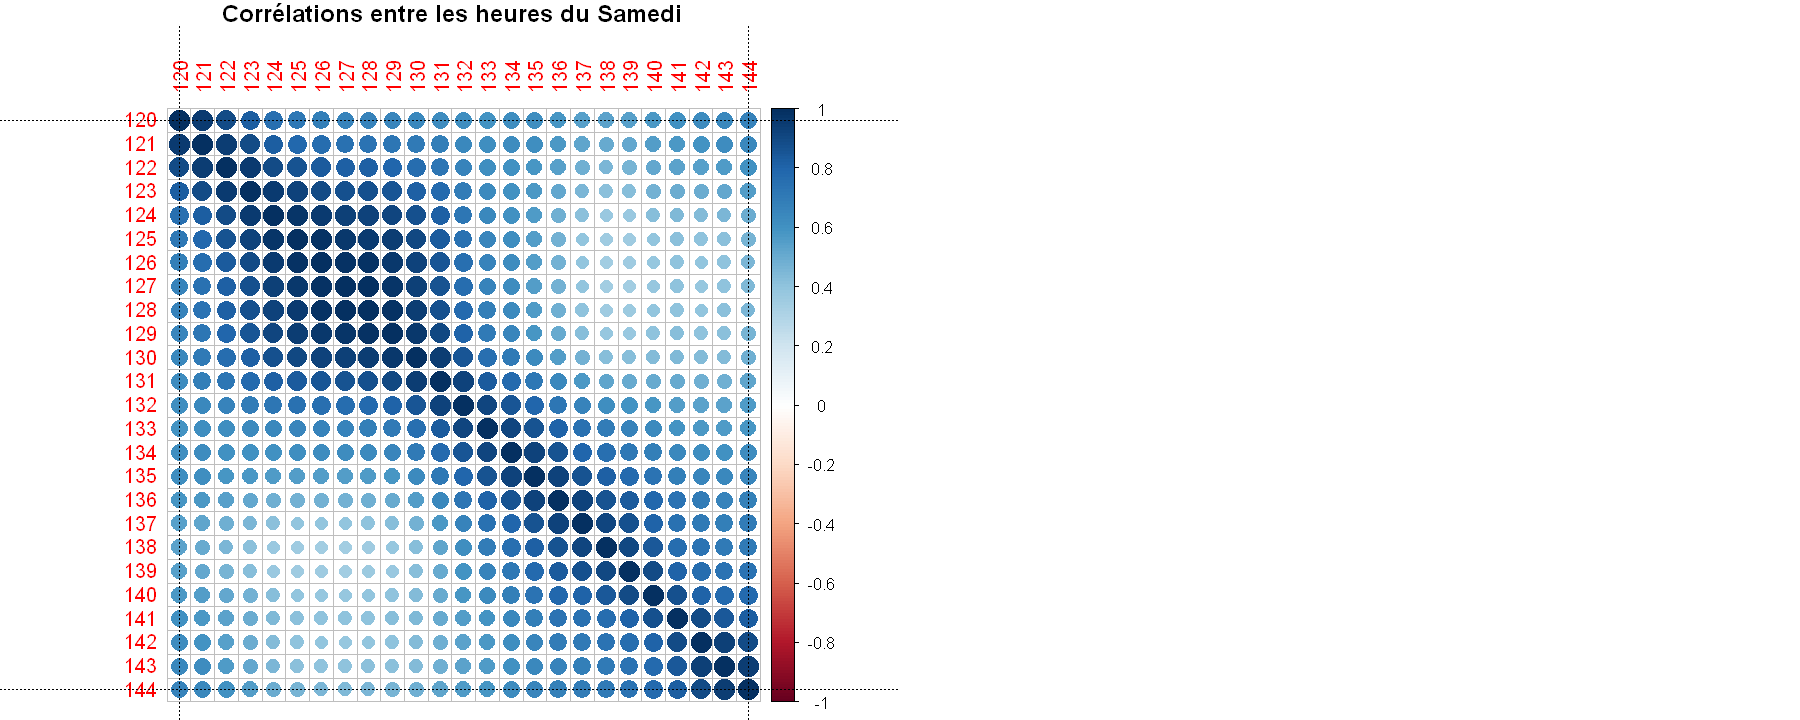

In [40]:
par(mfrow = c(1, 2))
corrplot(cormat[120:144, 120:144],title=" Corrélations entre les heures du Samedi",mar=c(0,0,1,0))
abline(v = timeTick, h = timeTick, col = "black", lty = "dotted")


Le week-end, on ne peut pas bien distinguer les phases (étant moins marquées que pour les jours ouvrés).
On voit également une évolution différente entre le matin (00h-12h) et le soir (13h-23h) le Samedi quant à l'utilisation des vélos.

4. Plot the stations coordinates on a 2D map (latitude versus longitude). Use a different color for stations which are located on a hill.

[1] 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0

[1] "blue" "blue" "blue" "blue" "blue" "blue" "blue" "blue" "blue" "blue"
[11] "red"  "blue" "blue" "blue" "blue" "blue" "blue" "blue" "blue" "blue"

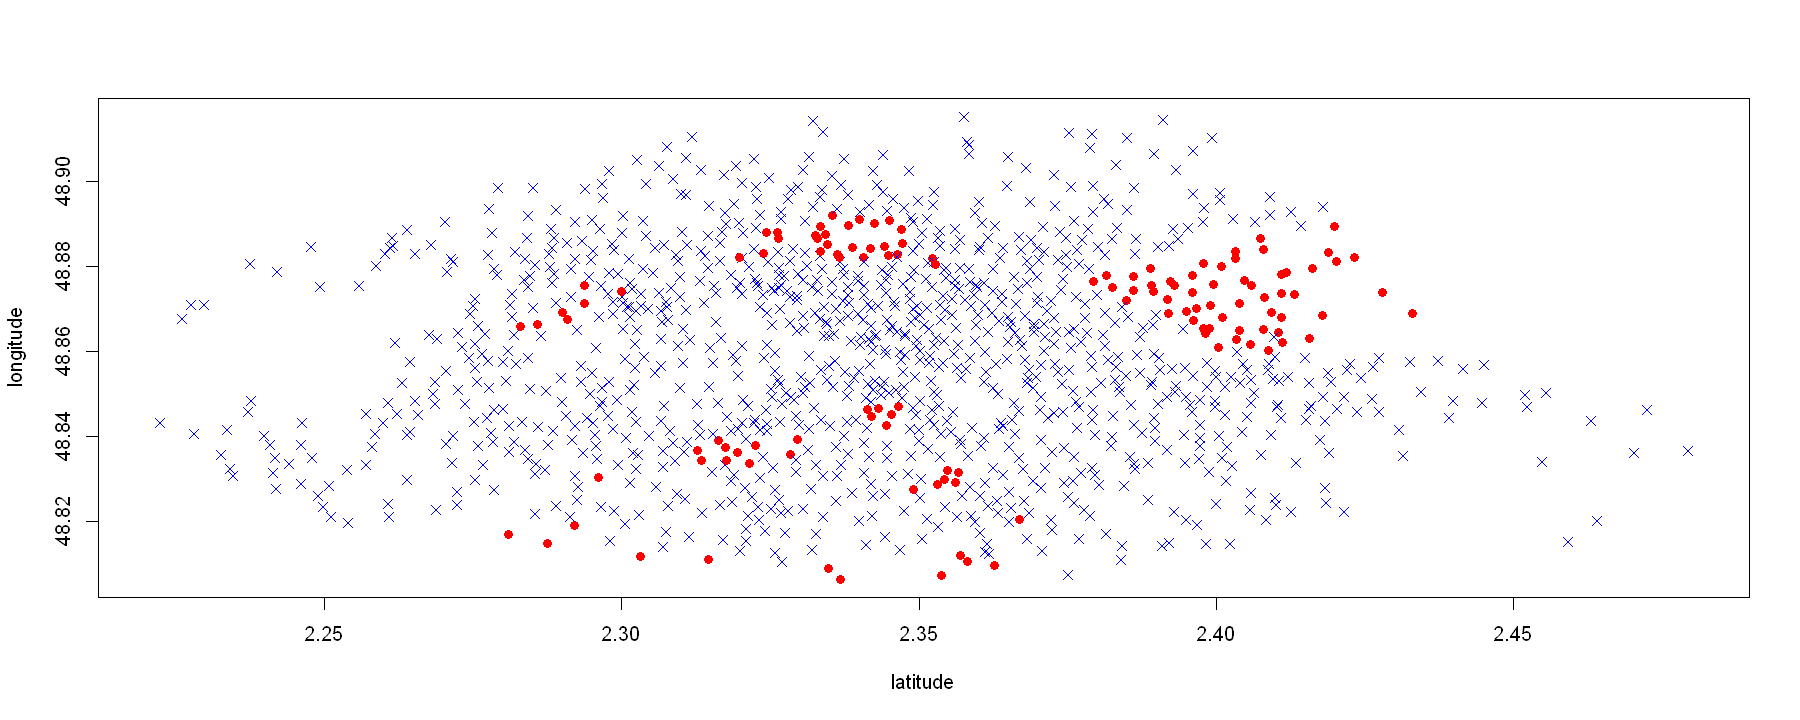

In [41]:
# Question 4

velib$bonus[1:20]
ifelse(velib$bonus[1:20] == 1, "red", "blue")

plot(velib$position$longitude, velib$position$latitude, 
     col = ifelse(velib$bonus == 1, "red", "blue"),
     xlab = "latitude", ylab = "longitude", 
     pch = ifelse(velib$bonus == 1, 19, 4))


Commentaires: ???

5. Redo questions 1-3 for the subset of stations which are located on a hill. Same questions for those who are not. Comment?

In [42]:
# Question 5
stationHill <- which(velib$bonus == 1)
stationNotInHill <- which(velib$bonus == 0)
stationHill

[1]   11   36   46   59   85   89   91  102  106  114  138  140  152  153  188
 [16]  191  204  224  233  247  257  275  302  303  307  326  327  328  329  346
 [31]  348  359  362  384  385  386  394  397  419  422  427  429  436  437  440
 [46]  442  446  450  457  461  463  473  479  480  489  504  518  520  523  524
 [61]  528  554  555  556  595  598  601  604  614  617  618  644  645  651  667
 [76]  669  675  692  713  717  724  726  734  755  762  765  770  806  828  865
 [91]  872  881  905  912  921  930  933  934  940  942  953  957  975  980  982
[106]  991  995  997 1001 1008 1028 1029 1068 1072 1076 1077 1088 1091 1093 1102
[121] 1109 1124 1133 1147 1153 1169 1187

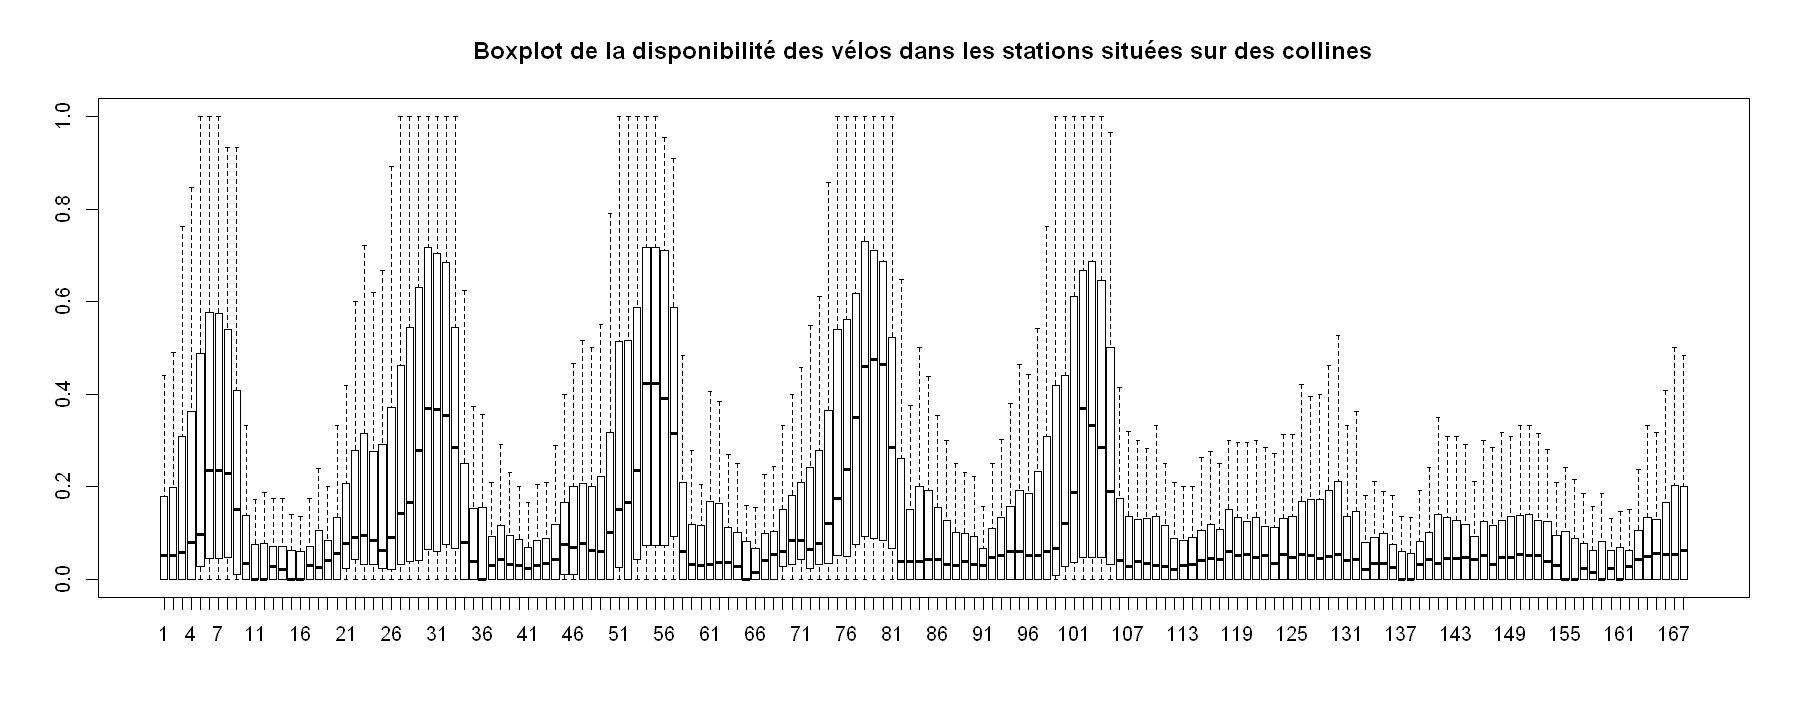

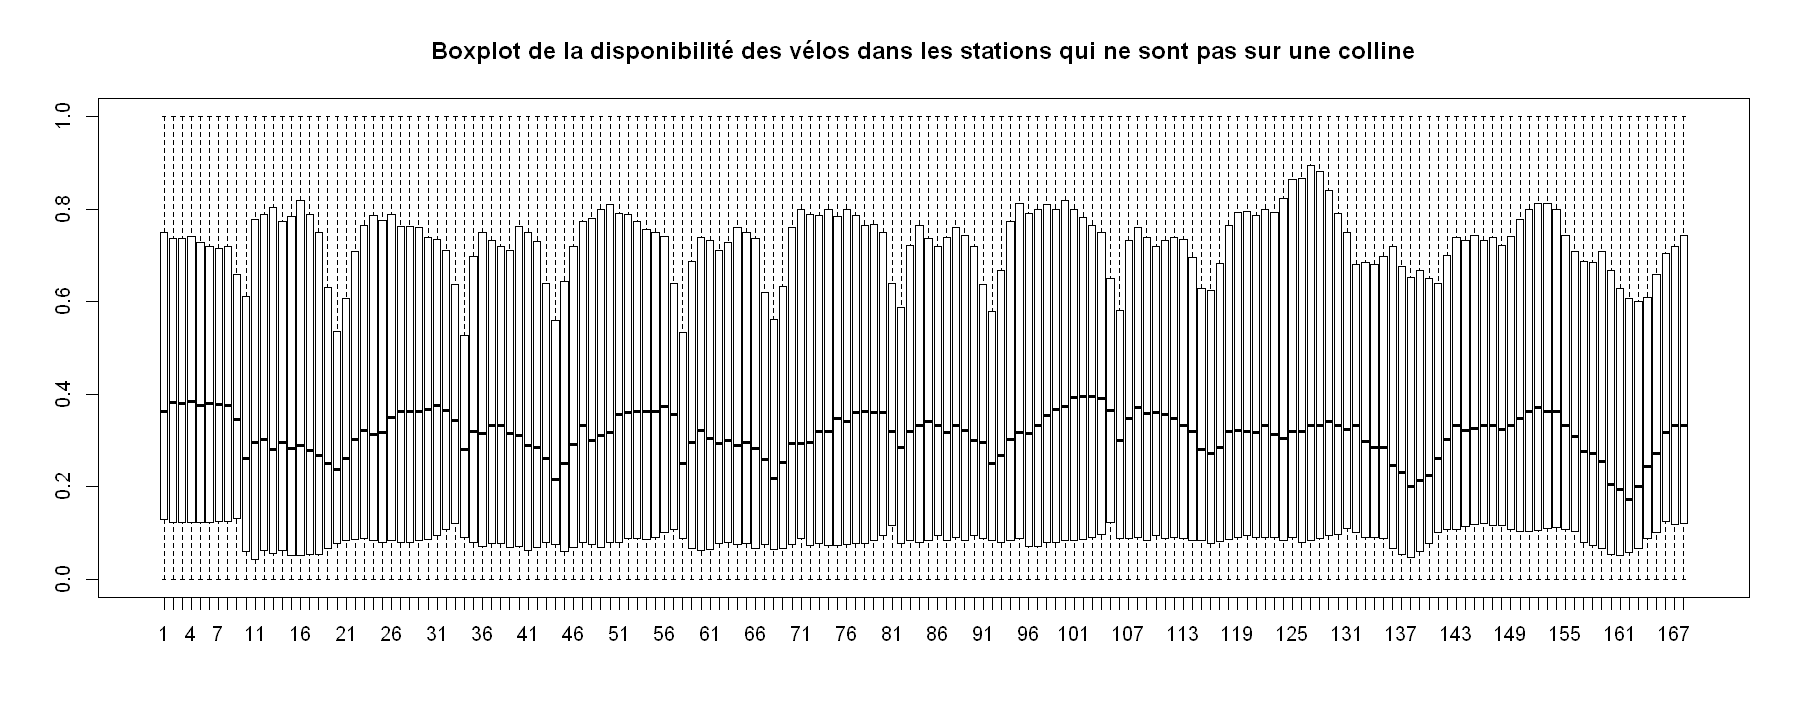

In [43]:
boxplot(x[stationHill, ],main="Boxplot de la disponibilité des vélos dans les stations situées sur des collines",outline=FALSE)
boxplot(x[stationNotInHill, ],main="Boxplot de la disponibilité des vélos dans les stations qui ne sont pas sur une colline")

Dans les stations situées en colline, la dispersion des variables est beaucoup plus marquée. Il y'a une asymétrie plus nette des données (médiane avec de fortes fluctuations). De plus, la différence entre jour ouvré et week end y est également plus visible. On a des composantes saisonnières avec différentes périodicités suivant qu'on est en week end ou pas.

# Principal component analysis

Some ideas :

1. Perform a PCA with package FactoMineR. Should the data be scaled?


<font color="blue">
Nous avons choisi ici de réduire les données pour l'analyse en composantes principales. Néanmoins, il ne devrait pas y avoir une grande différence si la réduction n'est pas faite car les boxplots des variables (représentés plus haut) montrent que la dispersion des données est pratiquement constante.
</font>

In [44]:
library("FactoMineR")
library("factoextra")

Warning message:
"package 'FactoMineR' was built under R version 3.6.3"
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Warning message:
"package 'factoextra' was built under R version 3.6.3"
Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [80]:
velib.pca=PCA(x,ncp=15,scale=TRUE,graph=FALSE)


2. Plot the percentage of variance explained by the first 15 components, as well as a boxplot of the coordinates of the indivuals on the 15 first principal axis. How many components can be kept?

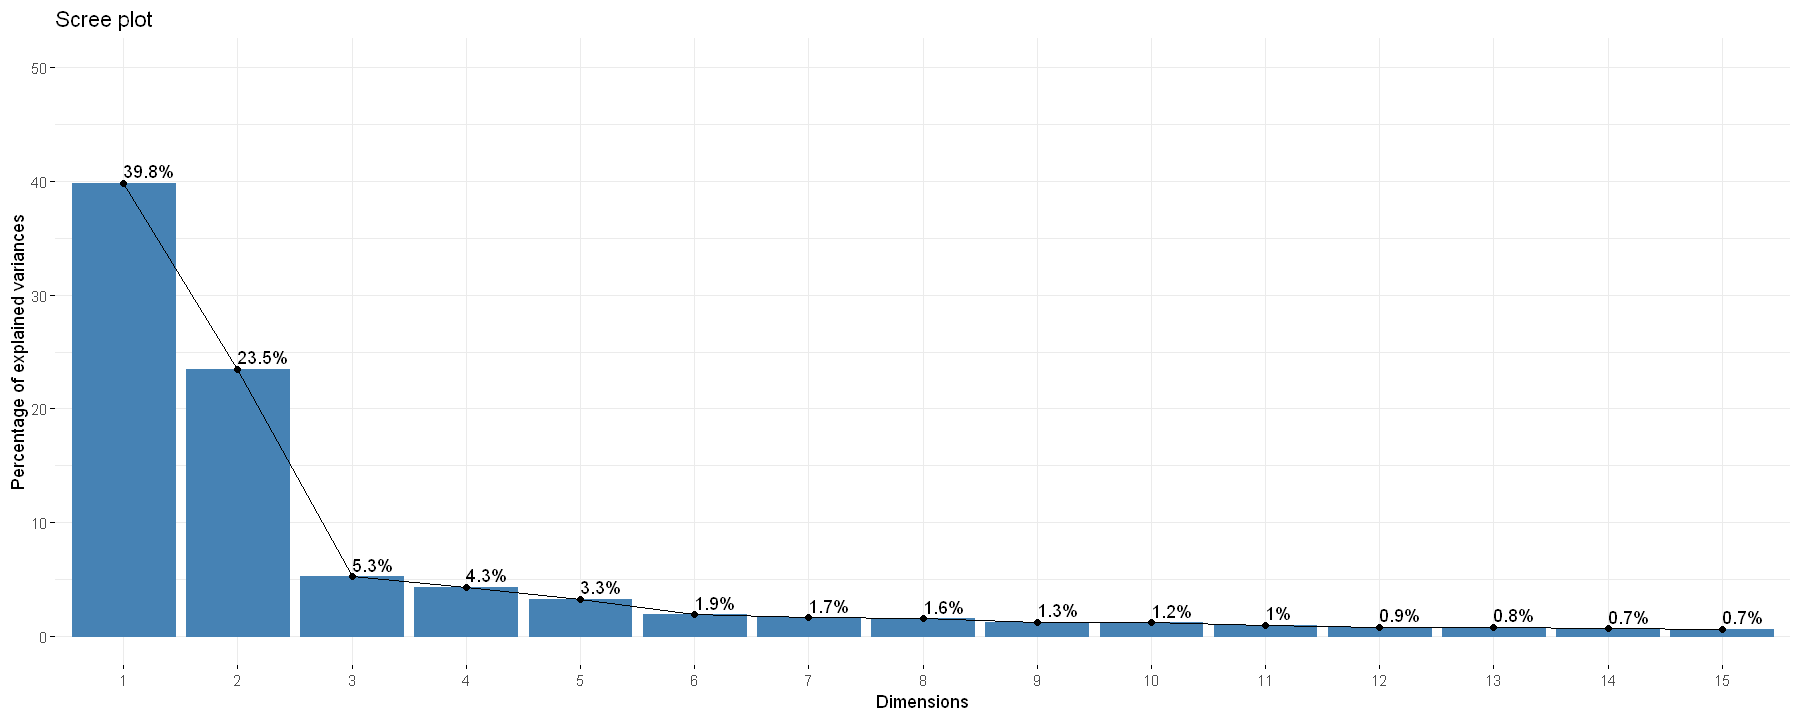

In [46]:
fviz_eig(velib.pca, ncp=15,addlabels = TRUE, ylim = c(0, 50))
#get_eigenvalue(velib.pca)[1:15,]

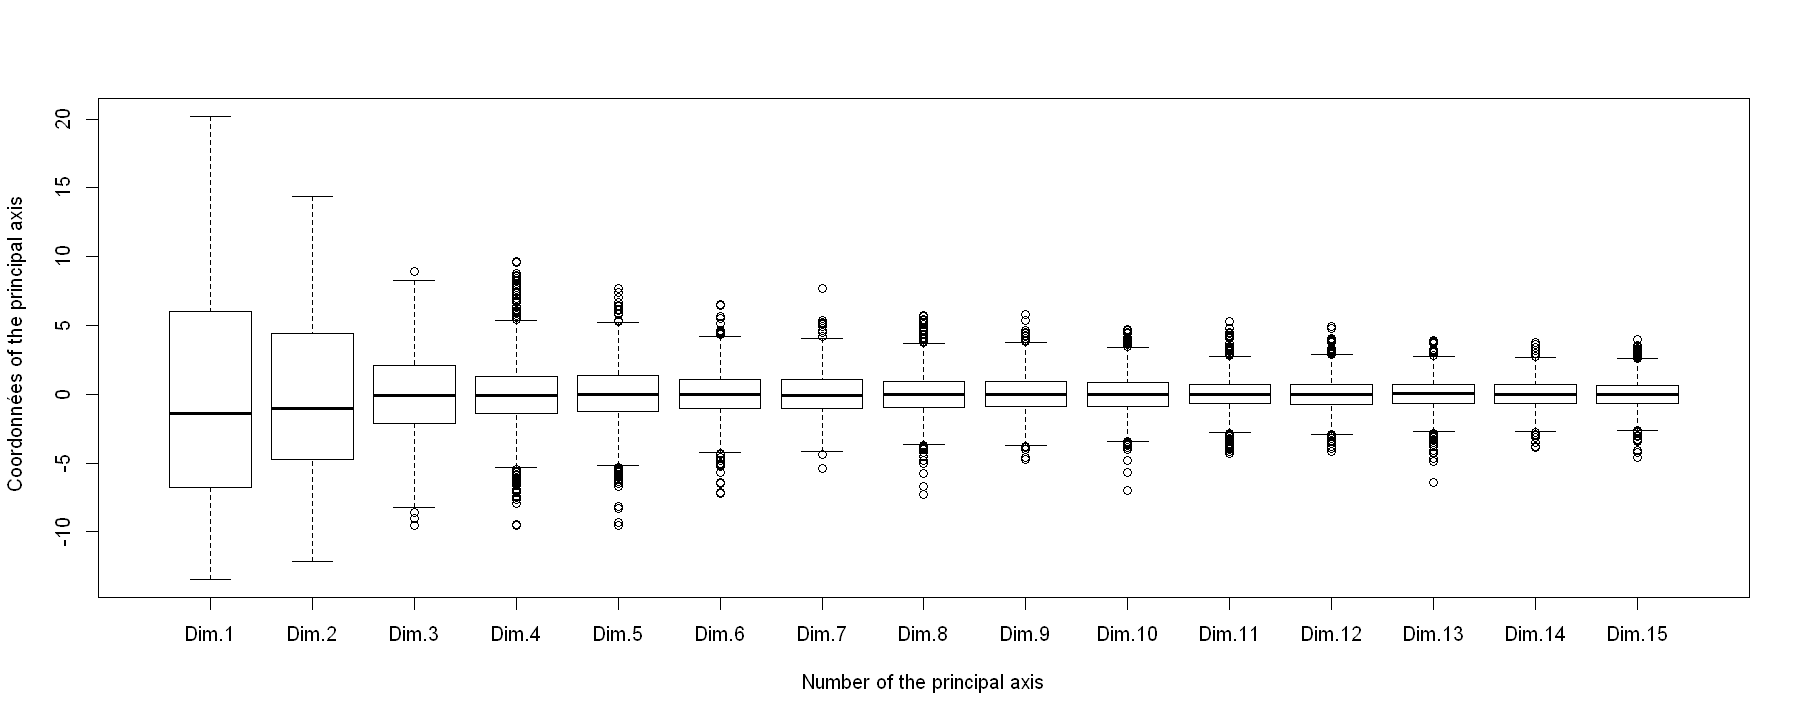

In [47]:
boxplot(velib.pca$ind$coord,ncp=15,xlab="Number of the principal axis", ylab=" Coordonnées of the principal axis")

<font color="blue">
En visualisant l'ébloui des valeurs propres, on voit qu'avec 5 composantes principales, on arrive à représenter plus de 76% de l'inertie totale.
De plus, les boxplots des coordonnées des individus montrent qu'à partir de la sixième composante, la variance est faible et se stabilise. Un choix de 5 composantes principales semble alors être judicieux. 
</font>

3. Plot the coordinates of the first 4 principal components on different graphs. Interpret the result (remember that the original variables are time steps).


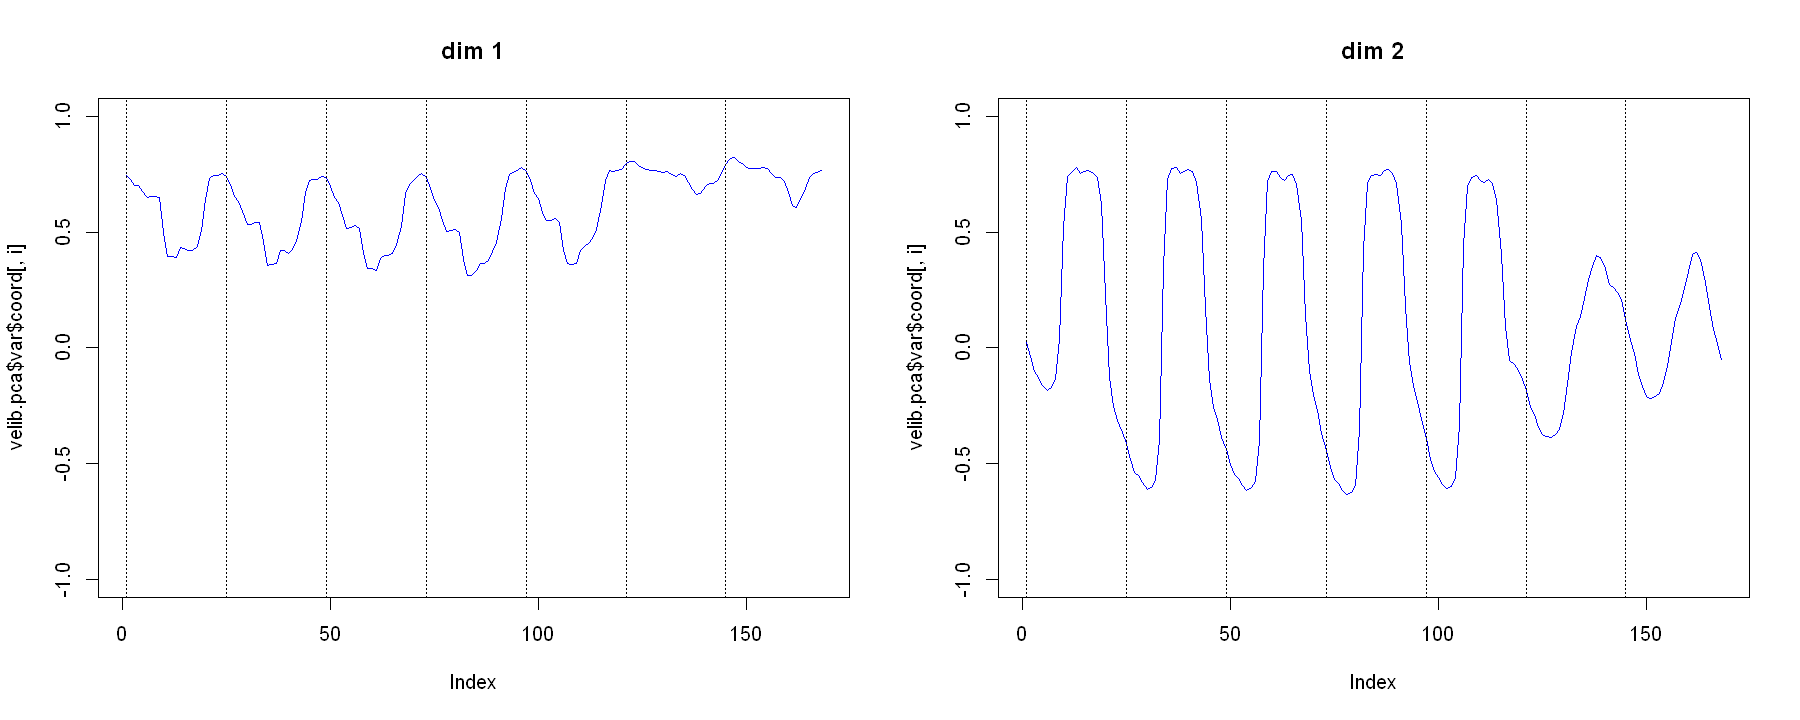

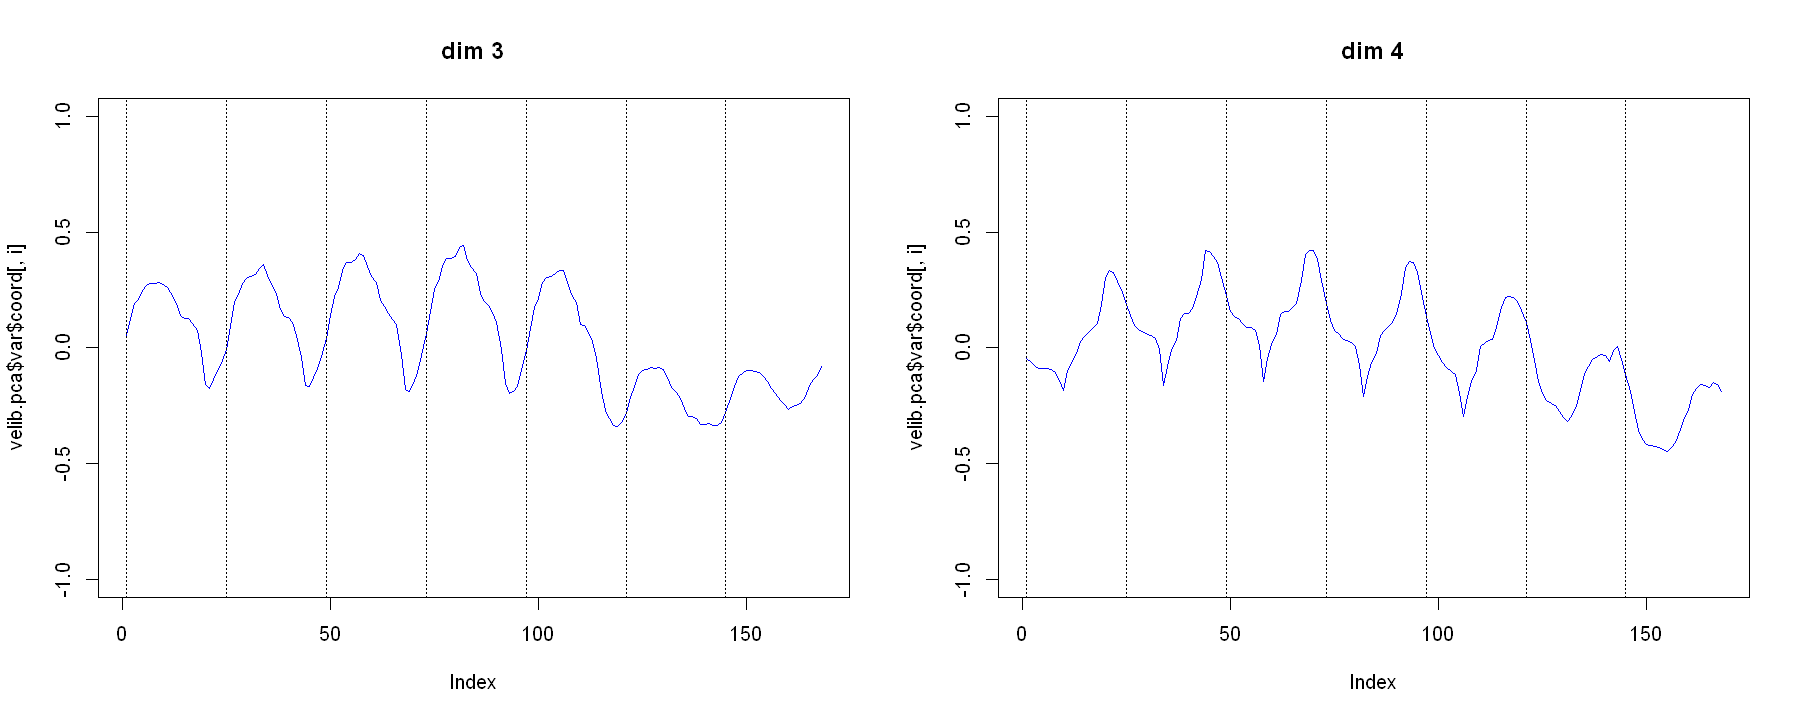

In [48]:
options(repr.plot.width = 15, repr.plot.height = 6)
par(mfrow = c(1, 2))
for (i in 1:4){
    plot(velib.pca$var$coord[,i ], col = "blue", type = "l", ylim = c(-1, 1),main=paste("dim",i))
    abline(v = timeTick, lty = "dotted")
}

<font color="blue">
Interpretation: ??
    </font>

4. Plot the circle of correlation. Interpret the result.

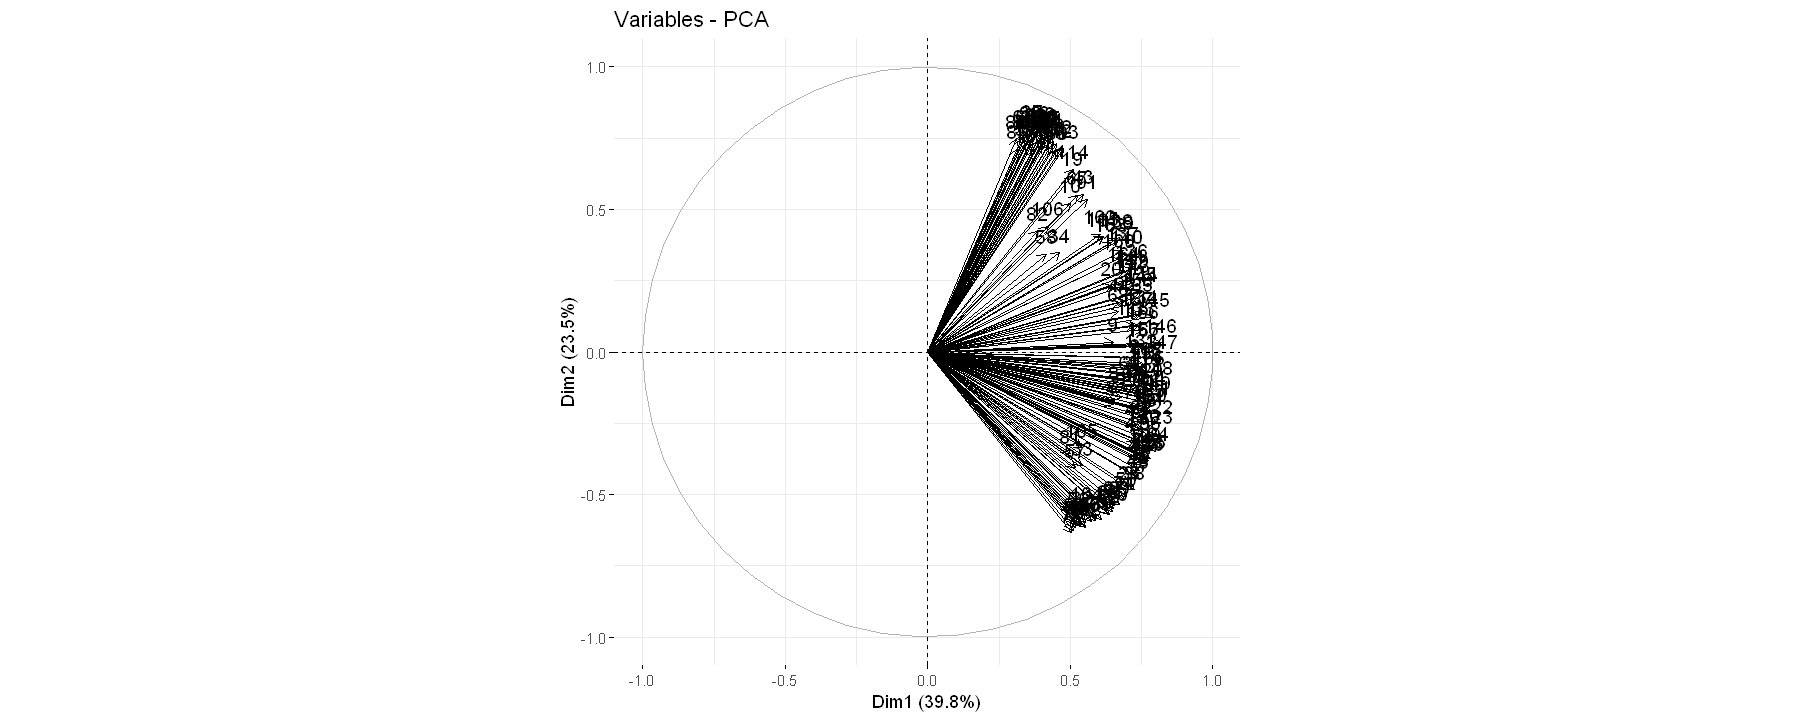

In [49]:
fviz_pca_var(velib.pca,axes = c(1,2))

<font color="blue">
On peut voir à partir du graphe ci-dessus que toutes les flèches sont proches du cercle ce qui signifie que les variables sont bien représentées sur les deux premiers axes. 
On remarque également que les abcisses de toutes les variables sont positives, la dimension 1 représente  une moyenne du ratio nombre de vélos disponibles sur nombre de vélos total.
La deuxième dimension, quant à elle, est un contraste entre deux types de variables: celles avec une projection sur l'axe des ordonnées positive et celles avec une projection négative (à compléter avec d'autres graphes).
 </font>

5. Plot the individuals on the plan spanned by the first two coordinates. Interpret the result.

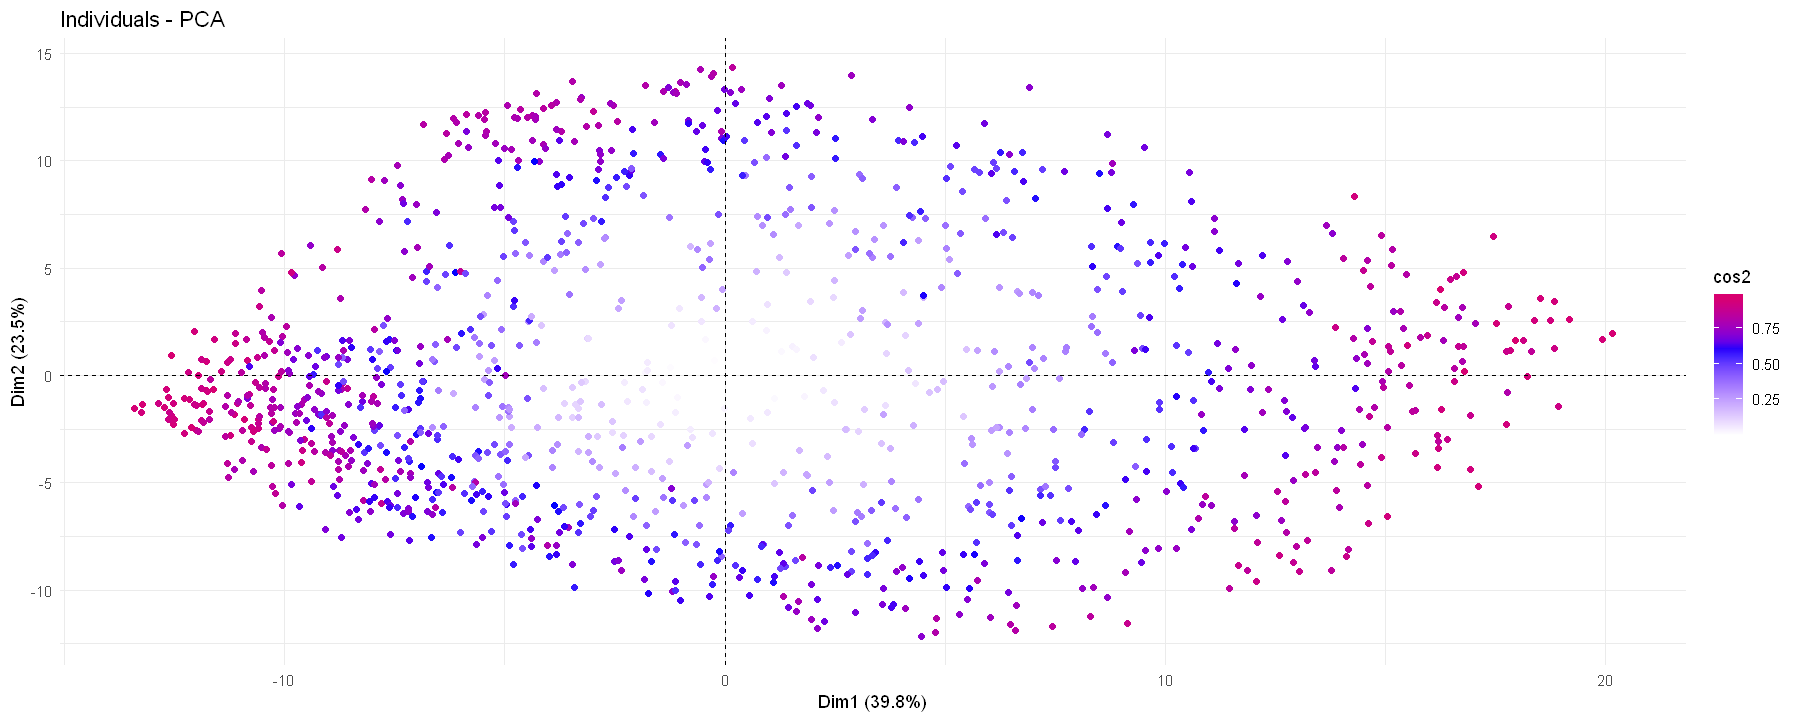

In [50]:
#fviz_pca_ind(velib.pca,axes = c(1,2))
#fviz_pca_ind(velib.pca,col.ind="cos2")
fviz_pca_ind(velib.pca, col.ind="cos2", axes = c(1,2),geom = "point") +
      scale_color_gradient2(low="white", mid="blue",
      high="red", midpoint=0.6, space = "Lab")+ theme_minimal()

<font color="blue">
Interprétation: 
  </font>

6. Add the information brought by the variable qualitative variable 'bonus', indicating whether a station is located on a hill or not. In particular, where are located these stations on the graph of individuals? Is it surprising?

In [51]:
#velib.pca2=PCA(x,ncp=15,scale=TRUE,quali.sup=velib$bonus)

In [52]:
# fviz_pca_ind(velib.pca, habillage=velib$bonus)

<font color="blue">
Interprétation: La première représentation qui affiche toutes les stations sur le plan à deux Dimensions n'est pas très interprétable. En effet les individus semblent répartis sur l'ensemble du plan formant un nuage disparse mais légèrement étroit sur les extrémités gauche et droite. Ca laisse voir que les coordonnées en devenant extrêmes (grandes ou petites) sur l'axe entraîne leur diminution selon l'axe 2.
    
Pour plus de lisibilité on représente les individus selon leur contribution à la construction des 2 axes. On voit là que les points au centre du plan contribuent très peu. Les stations significatives sont celles ayant des coordonnées assez grandes sur l'un des deux axes ( surtout sur l'axe 1). Donc la dim 1 qui était une moyenne du remplissage des stations est généralement soit assez grande ou soit assez petite. 
  </font>

7. Implement questions 1-6 in Python. For that, you can have a look at the notebook on MARS, of https://github.com/wikistat/Exploration/3. 

## Clustering K-Means

In [53]:
#help (clusGap)
#reskm <- kmeans(x, centers = K)
#plot(reskm$centers[i, ])
#x[which(reskm$cluster==i), ]



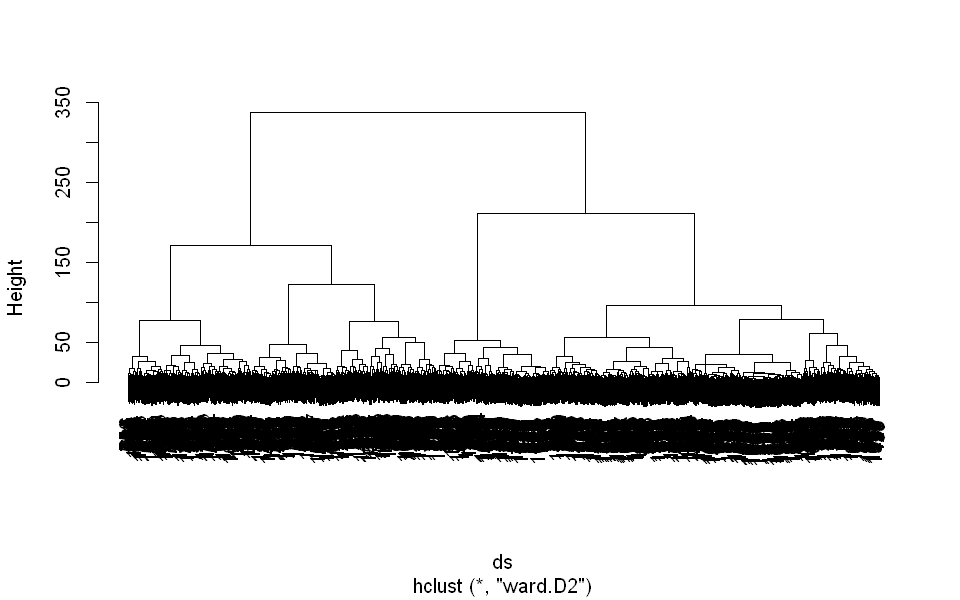

In [54]:
#Choix du nombre de classe

ds=dist(scale(x))
# classification hiérarchique
hc.ds = hclust(ds,method="ward.D2")
options(repr.plot.width=8, repr.plot.height=5)
plot(hc.ds,main="")  # dendogramme

<font color="blue">
Interprétation: On affiche le dendrogramme pour faire un premier choix du nombre de classes. On a 
  </font>

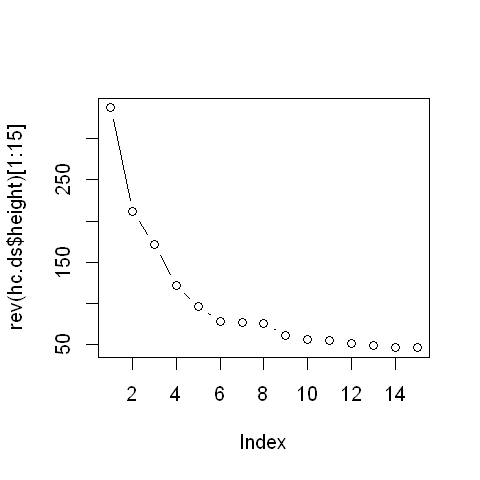

In [55]:
# choix du nombre de classes
options(repr.plot.width=4, repr.plot.height=4)
#help (hclust)
plot(rev(hc.ds$height)[1:15],type="b")

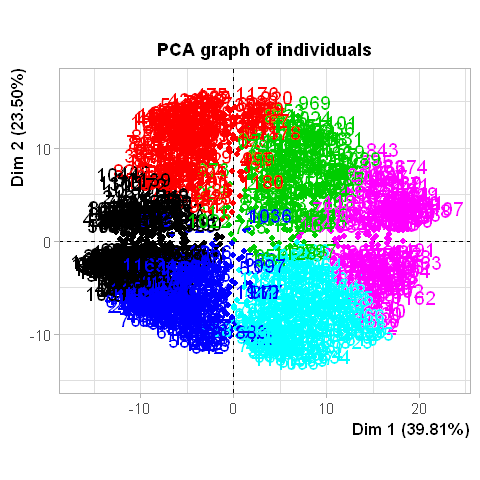

In [56]:
kvelib=kmeans(scale(x),6) 
color=kvelib$cluster
plot(velib.pca,choix="ind", habillage="ind",col.hab=color)

In [57]:
library(cluster)

clusGap(x, FUN = kmeans, K.max = 6, B = 3)

#SE.sim = erreur standard (variance ) de chaque classe

Clustering Gap statistic ["clusGap"] from call:
clusGap(x = x, FUNcluster = kmeans, K.max = 6, B = 3)
B=3 simulated reference sets, k = 1..6; spaceH0="scaledPCA"
 --> Number of clusters (method 'firstSEmax', SE.factor=1): 6
         logW   E.logW       gap      SE.sim
[1,] 7.493545 8.012039 0.5184940 0.003867299
[2,] 7.318368 7.930498 0.6121297 0.003783954
[3,] 7.203486 7.895951 0.6924650 0.004774305
[4,] 7.142235 7.868289 0.7260538 0.002728957
[5,] 7.111424 7.855362 0.7439387 0.002184936
[6,] 7.078552 7.845374 0.7668217 0.003337021

### K-means sur les données centrées réduites

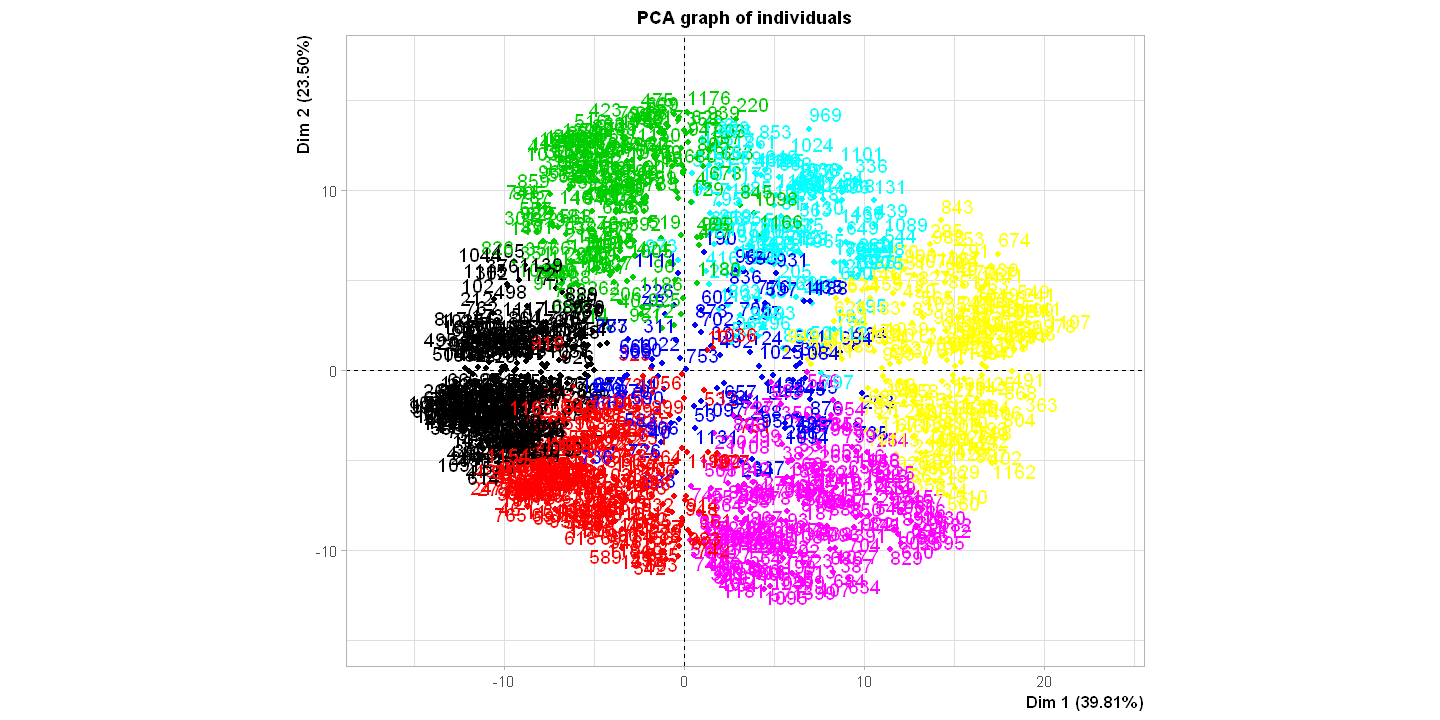

In [90]:
acp_red=PCA(x,ncp=5,graph=F)

res.velib_pca=HCPC(acp_red,graph=F,nb.clust=7)
plot(acp_red, choix="ind", habillage="ind",col.hab=res.velib_pca$data.clust$clust)

# A voir en interprétant si on repasse à 5 classes

## K-means (version 2)

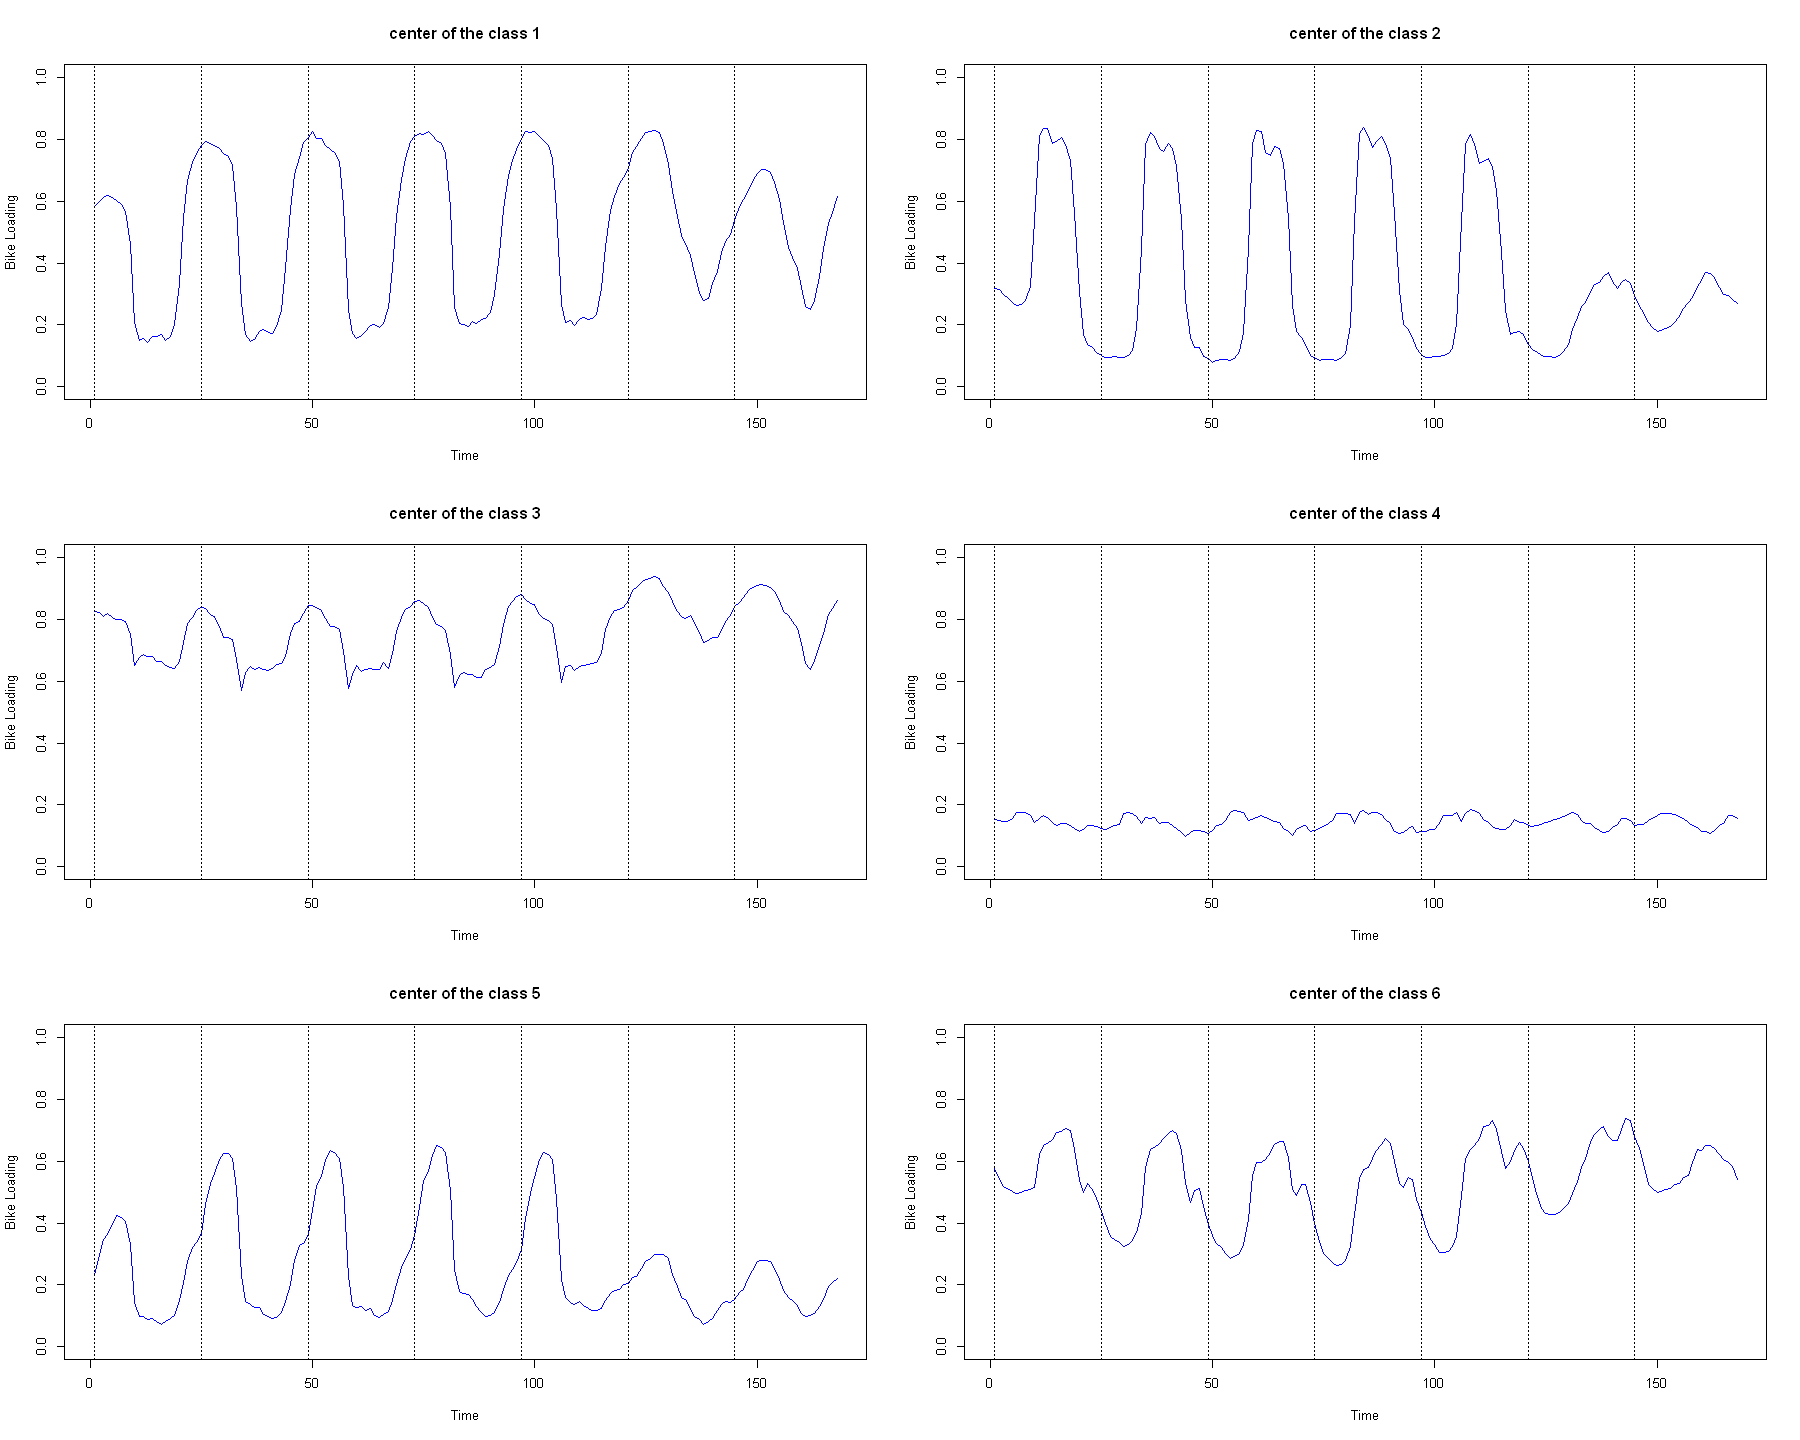

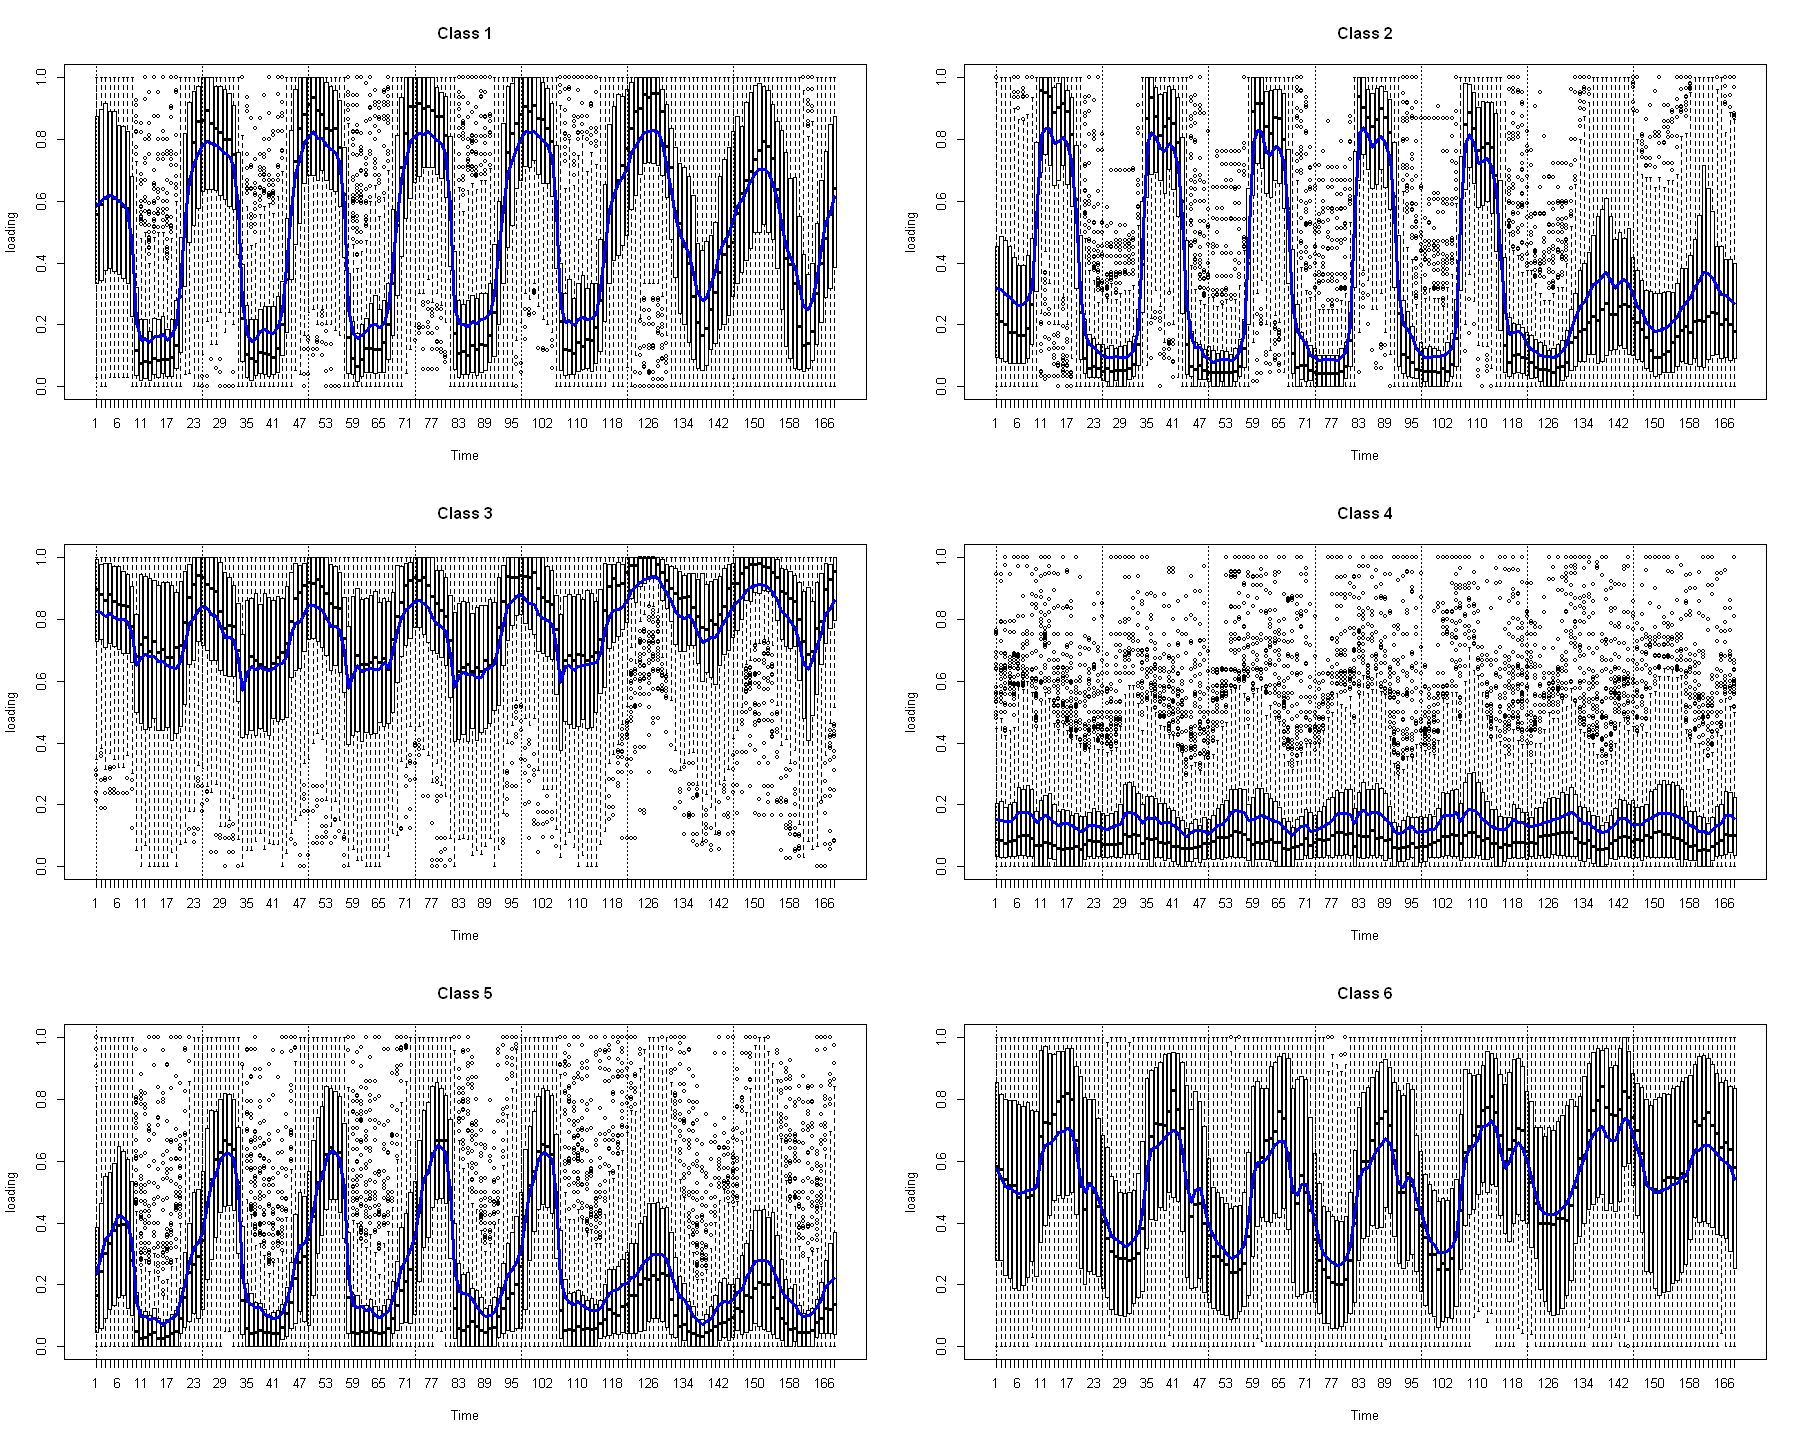

In [59]:

k<- 6
kmeans_res <- kmeans (x, centers=k)
#kmeans_res <- kmeans (x, centers=k,nstart=10)
#modif suggéré par le prof pour avoir un minimum global et pas un minimum local
options(repr.plot.width = 15, repr.plot.height = 12)

par (mfrow=c(3,2))
for (i in 1:k) {
    plot (kmeans_res$centers [i,], col= "blue", type="l", ylim=c(0,1), xlab="Time",ylab="Bike Loading", main = paste ("center of the class", i))
    abline (v=timeTick,lty="dotted")
}

par(mfrow=c(3,2))
for (i in 1:k){
  boxplot(x[which(kmeans_res$cluster==i),],xlab="Time", ylab="loading", main=paste("Class",i))
  lines(kmeans_res$centers[i,],col="blue",lwd=3)
  abline(v=timeTick,lty="dotted")
}




<font color="blue">
classe 1 -> comportement opposé à classe 2 (+ différence jours ouvrés et week end)
classes 4 et 6 -> même schéma d'occupation avec différentes intensités
classe 3 -> même occupation pour tous les jours
comparer classes 5 et 6    
</font>

### Interprétation pistes
Chaque classe montre un comportement différent dans l'utilisation des velos
dim 2= contraste jour nuit
les boxplots sont bien centrés autour des moyennes.


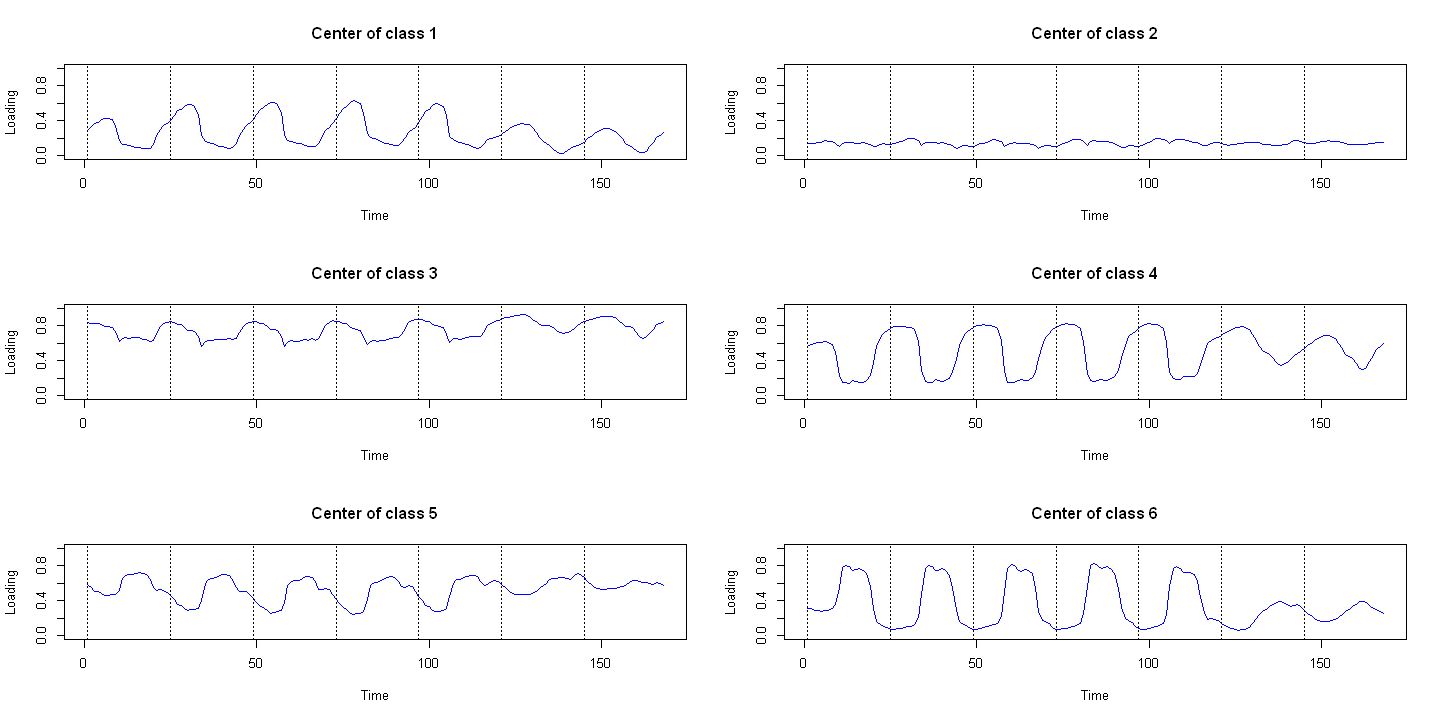

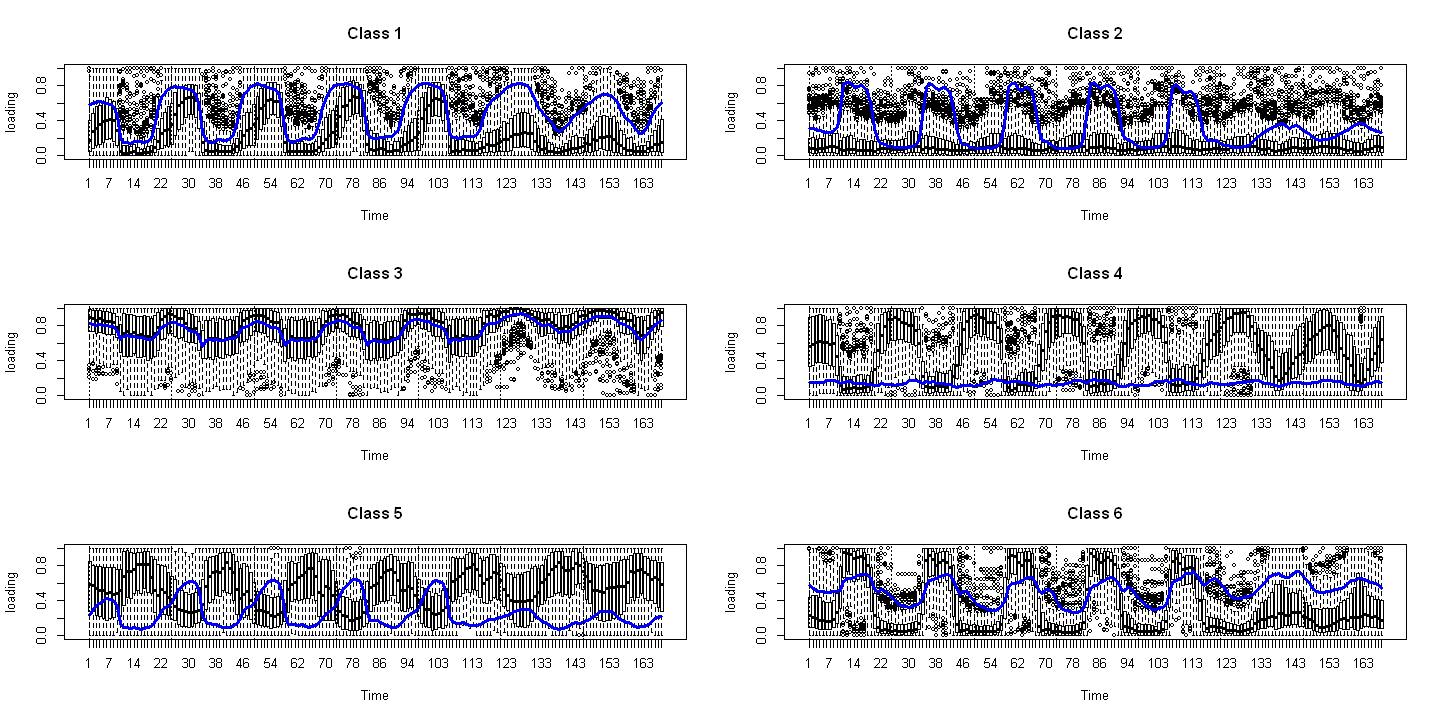

In [60]:
p <- 5  # number of principal components
K=6
reskmPCA <- kmeans(velib.pca$ind$coord[, 1:p], centers = K, nstart = 10)   # use the same as previously chosen
reskmPCAcenters <- matrix(nrow = ncol(x), ncol = K)
for (i in 1:K){
    reskmPCAcenters[, i] <- velib.pca$call$centre + 
    velib.pca$call$ecart.type * velib.pca$var$coord[, 1:p] %*% (as.matrix(reskmPCA$centers[i, ], ncol = 1) / sqrt(velib.pca$eig[1:p, 1])) # coord. in the orig. space
}

par(mfrow=c(3,2))
options(repr.plot.width=12, repr.plot.height=6)
for(i in 1:K){
    plot(reskmPCAcenters[ ,i],ylim=c(0,1),
        type="l",col= "blue",
        ylab= "Loading", xlab= "Time",
        main= paste("Center of class", i))
    abline(v= timeTick,lty="dotted")
}

par(mfrow=c(3,2))
options(repr.plot.width=12, repr.plot.height=6)


for (i in 1:k){
  boxplot(x[which(reskmPCA$cluster==i),],xlab="Time", ylab="loading", main=paste("Class",i))
  lines(kmeans_res$centers[i,],col="blue",lwd=3)
  abline(v=timeTick,lty="dotted")

}

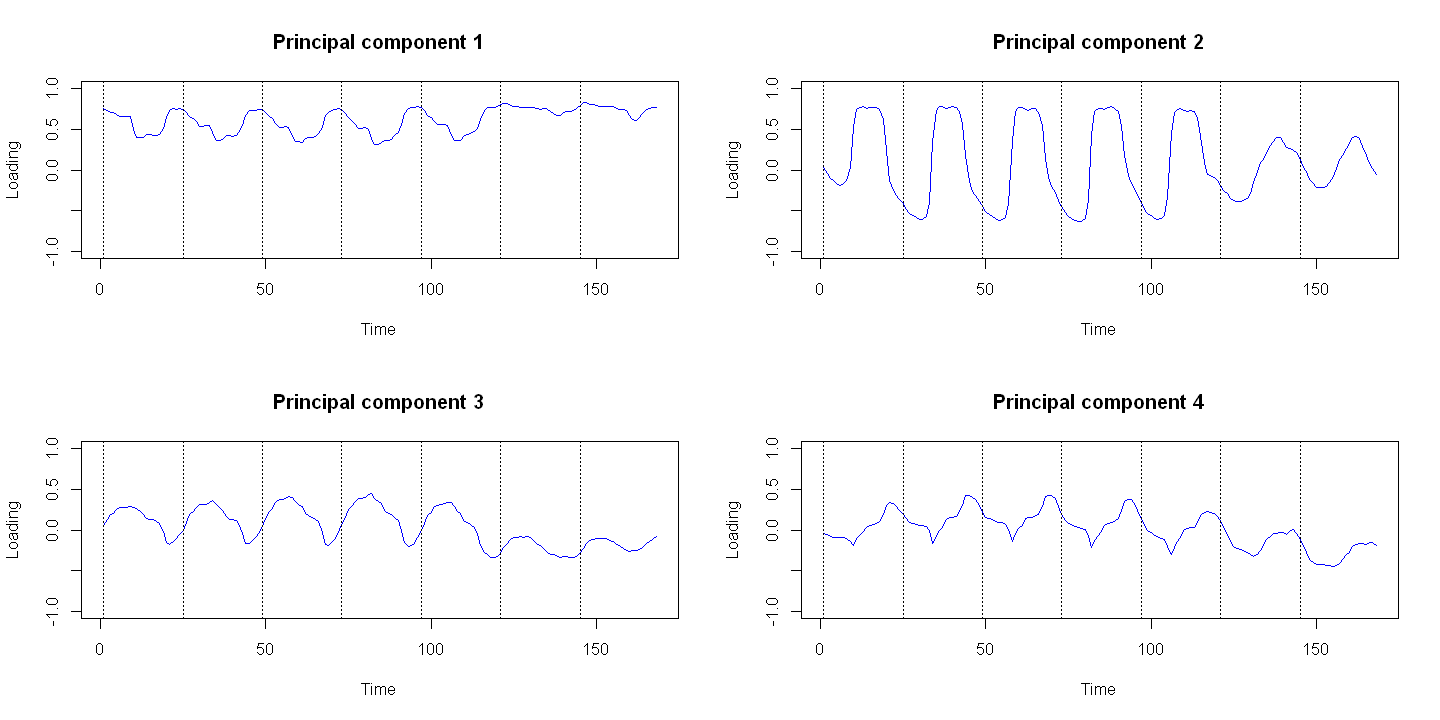

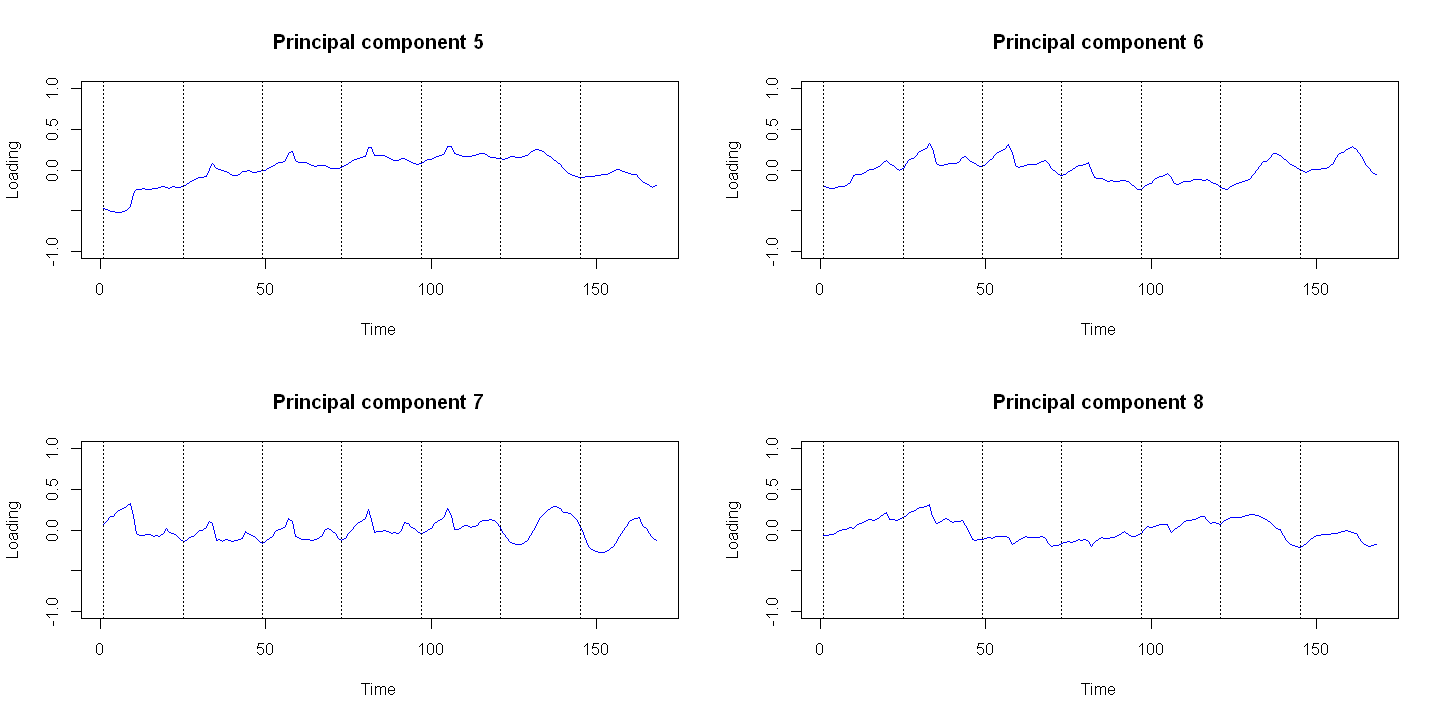

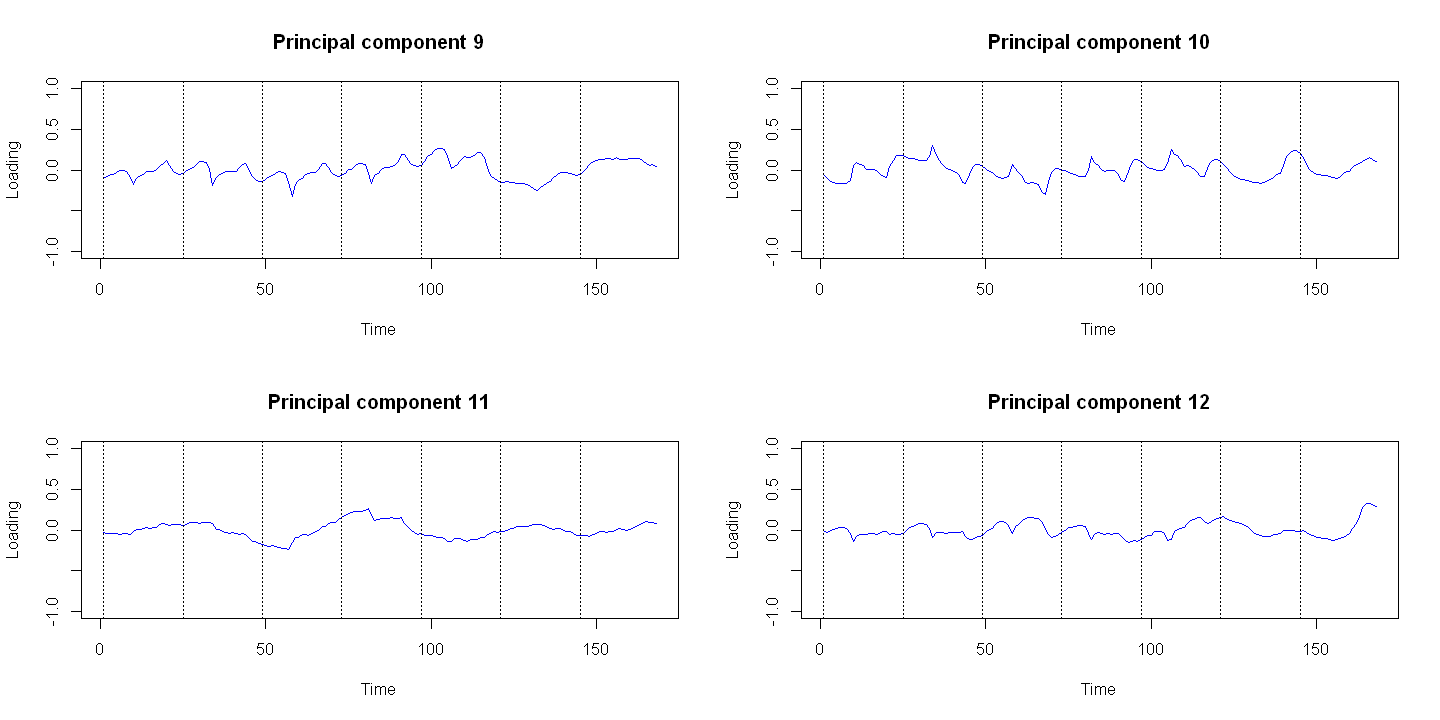

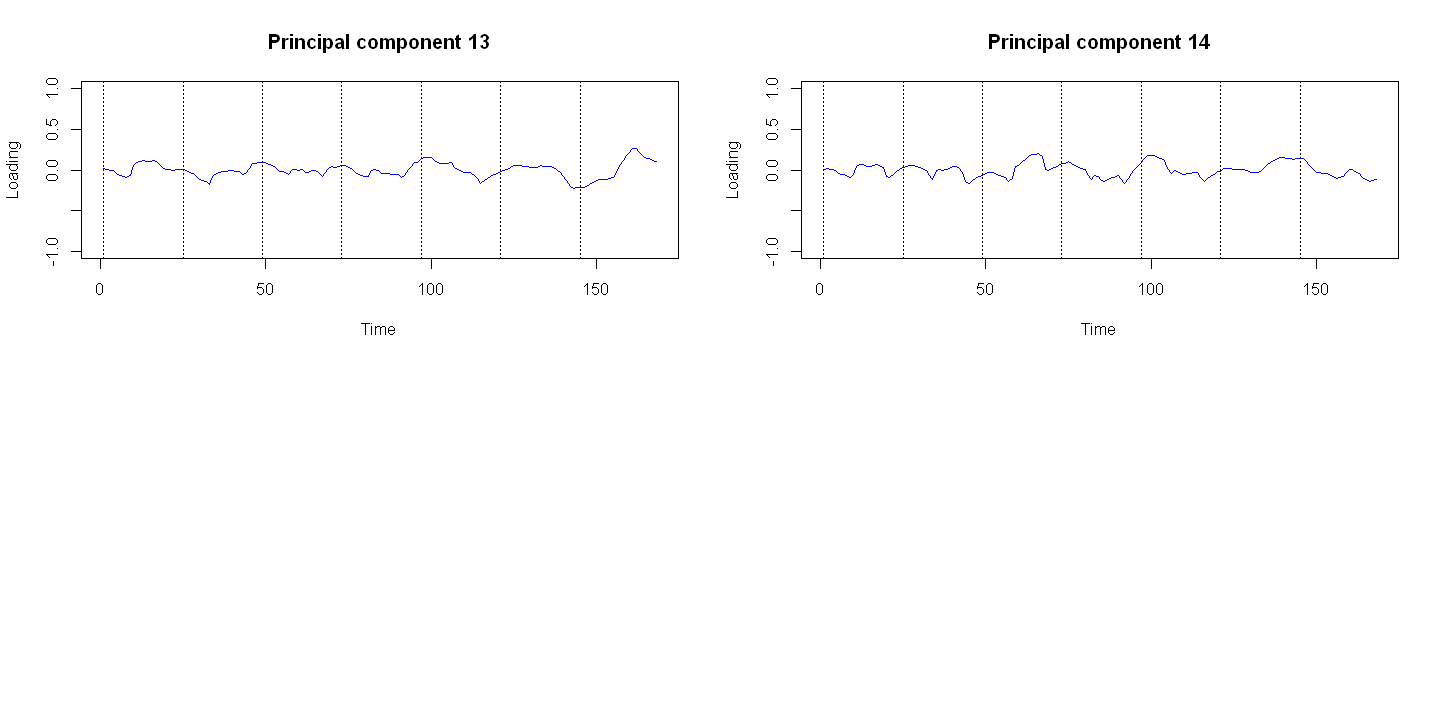

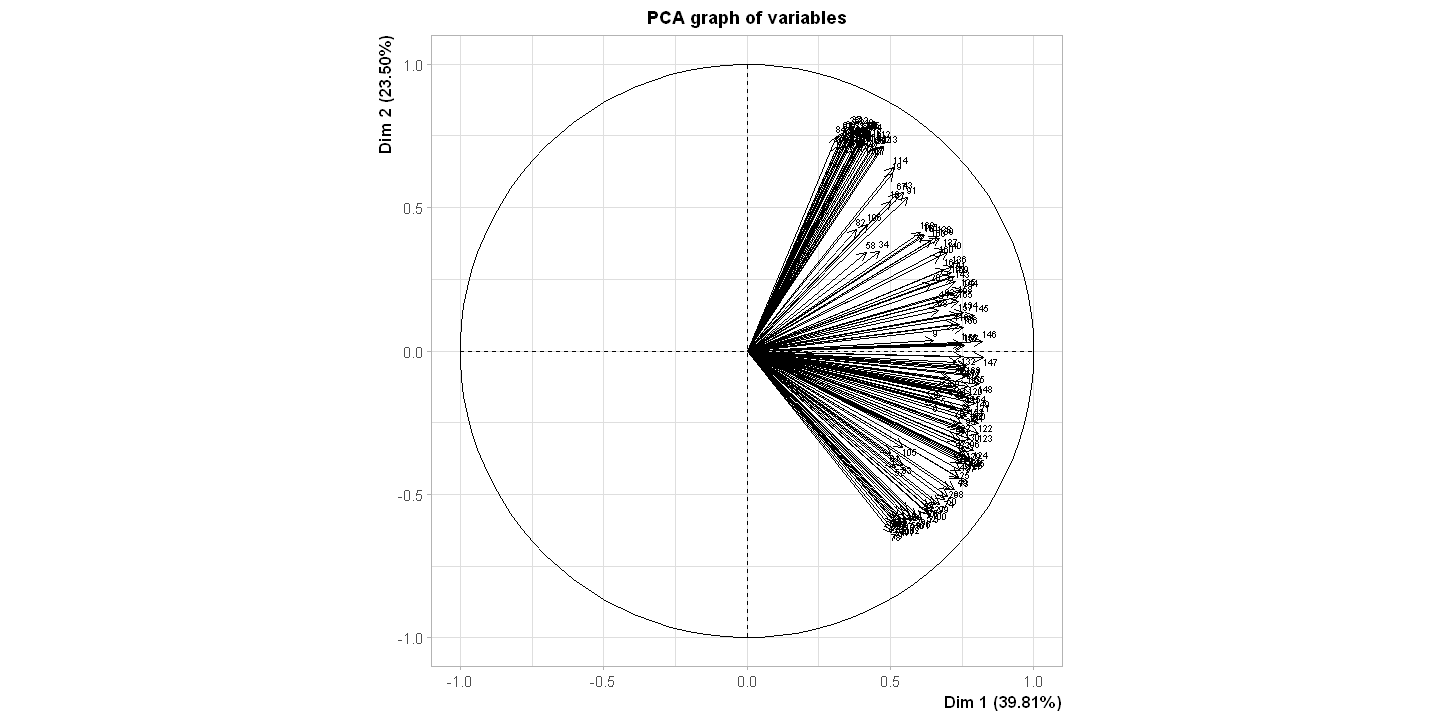

In [61]:
#interpretation of principal components
par(mfrow=c(2,2))
options(repr.plot.width=12, repr.plot.height=6)
for(i in 1:14){
    plot(velib.pca$var$coord[ ,i],ylim=c(-1,1),
        type="l",col= "blue",
        ylab= "Loading", xlab= "Time",
        main= paste("Principal component", i))
    abline(v= timeTick,lty="dotted")
}
par(mfrow=c(1,1))
plot(velib.pca,axes=c(1,2),choix= "var",cex=0.5,lwd=0.5)


In [62]:
#kmeans(x,k=6,nstart=10)

## Mélanges gaussiens

In [180]:

library(mclust)


[1] "mclustBIC"

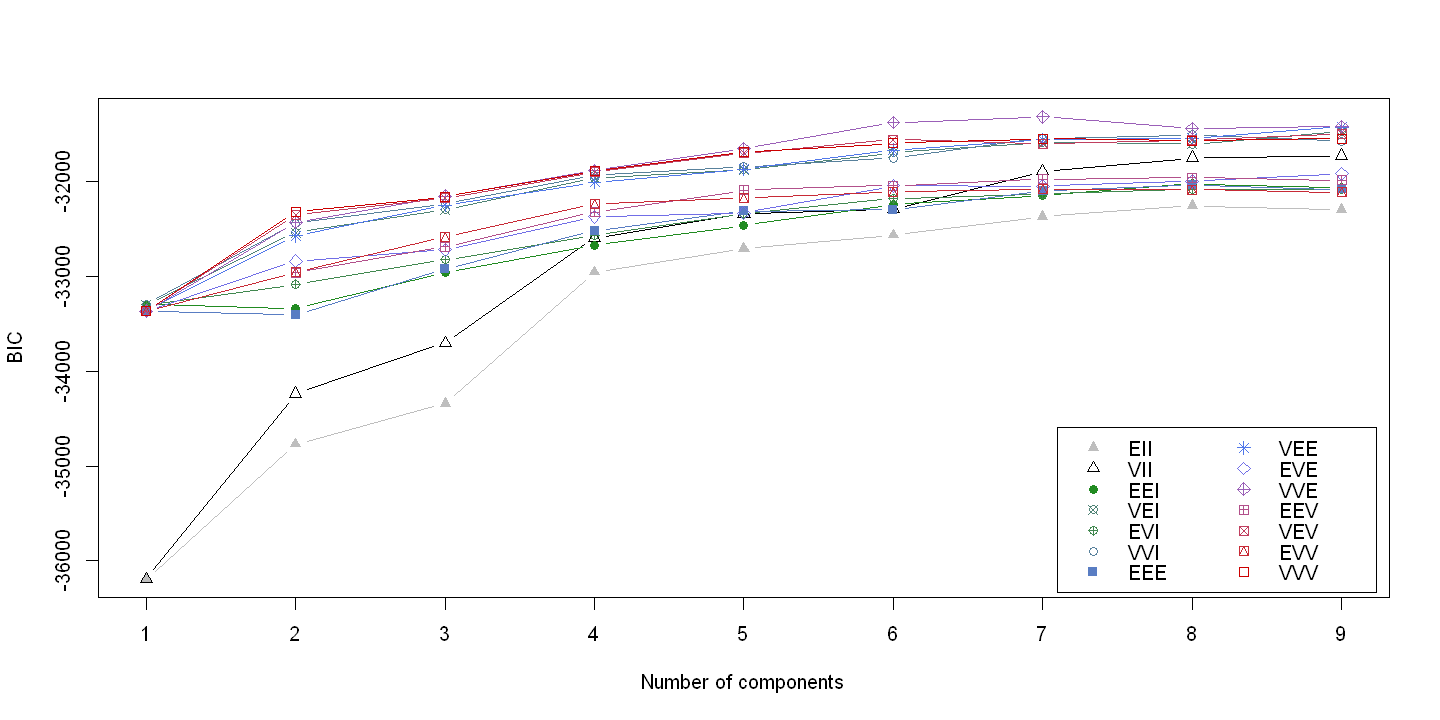

In [205]:

ACPvelib<-as.matrix(velib.pca$ind$coord[,1:5])
# print(velib.pca$var$coord)
MG<-mclustBIC(ACPvelib)
plot(MG)
class(MG)

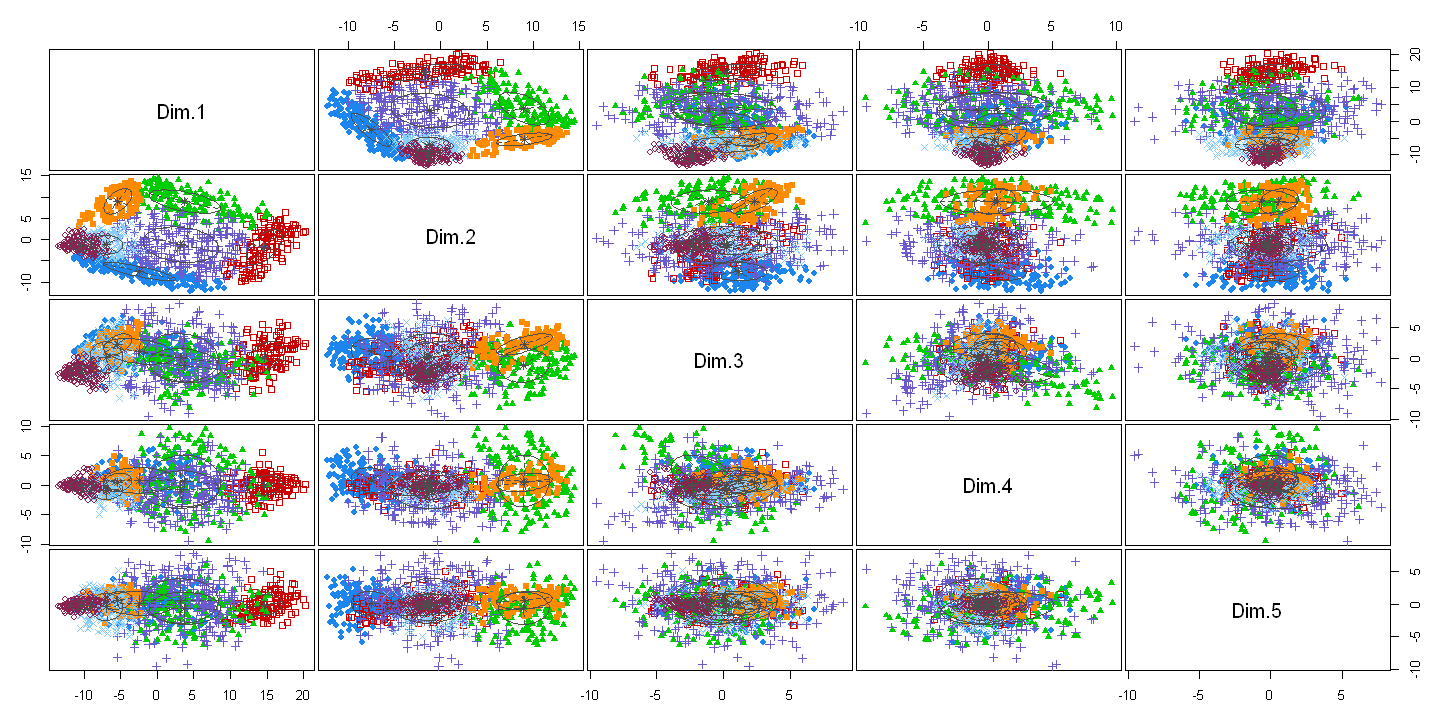

In [251]:
MG2<-Mclust(ACPvelib,x=MG)
plot(MG2,what="classification")

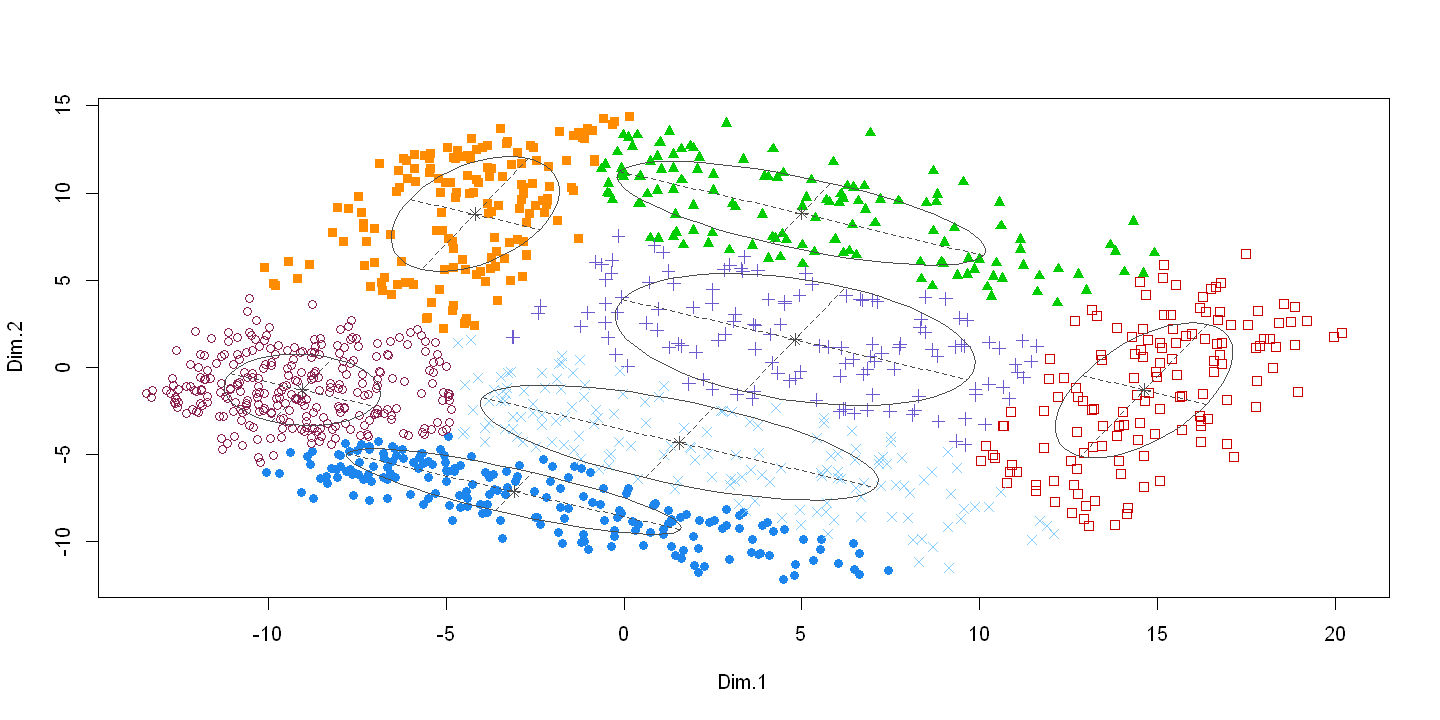

In [250]:
MG2<-Mclust(ACPvelib[,1:2],x=MG)
plot(MG2,what="classification")

In [262]:
help(densityMclust)

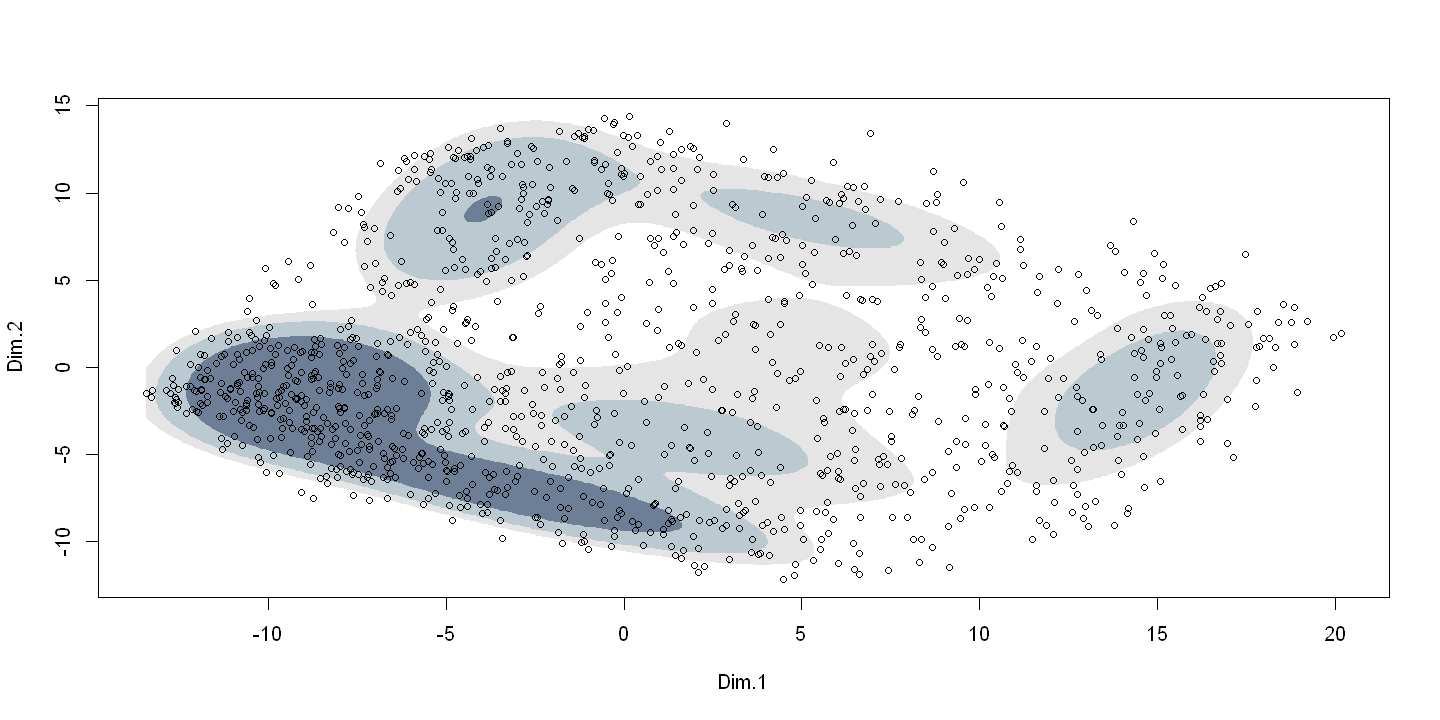

In [267]:

MG3=densityMclust(ACPvelib[,1:2],x=MG,modelnames="VVE")
# print(MG3$data)
plot(MG3,what="density",type="hdr",data=ACPvelib[,1:2],nlevel=7)